# TFTrade Model Experiments 


__Financial Prediction research (Synthetic Markets)__


Research about financial prediction on synthetic markets.
Deriv Synthetic instruments are be used.



In [483]:
# !pip install pandas-ta

# Import Libraries

In [484]:
# base import
import os
import sys
import json
import yaml
import time
import random 
import numpy as np
import pandas as pd
import pandas_ta as ta
import sklearn as sk
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt

# import MetaTrader5 as mt5
from packages.mt5any import MetaTrader5

from typing import List, Tuple
from datetime import datetime, timedelta

import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from IPython.display import clear_output
# import jtplot module in notebook
# from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# jtplot.style(theme='solarizedd')
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [485]:
# plt.style.available
plt.style.use('seaborn-v0_8-whitegrid')

In [486]:
def set_seeds(seed=100):
    random.seed(seed)          # Set seed for Python's random module
    np.random.seed(seed)       # Set seed for NumPy's random module
    torch.manual_seed(seed)    # Set seed for PyTorch
    torch.cuda.manual_seed(seed)  # Set seed for CUDA if using GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for cuDNN
    torch.backends.cudnn.benchmark = False      # Disable the benchmark for deterministic results

set_seeds()

# Library Version and Docs

In [487]:
print("Library version:")
print("\t-  pandas: {}".format(pd.__version__))
print("\t-  numpy: {}".format(np.__version__))
print("\t-  sklearn: {}".format(sk.__version__))
print("\t-  matplotlib: {}".format(matplot.__version__))
print("\t-  python: {}".format(sys.version[:sys.version.find('(') - 1]))

Library version:
	-  pandas: 2.2.3
	-  numpy: 1.26.4
	-  sklearn: 1.5.2
	-  matplotlib: 3.9.2
	-  python: 3.11.10 | packaged by conda-forge |


In [488]:
df = pd.DataFrame()

df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [489]:
help(ta.sma)

Help on function sma in module pandas_ta.overlap.sma:

sma(close, length=None, talib=None, offset=None, **kwargs)
    Simple Moving Average (SMA)
    
    The Simple Moving Average is the classic moving average that is the equally
    weighted average over n periods.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/simple-moving-average-sma/
    
    Calculation:
        Default Inputs:
            length=10
        SMA = SUM(close, length) / length
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 10
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        adjust (bool): Default: True
        presma (bool, optional): If True, uses SMA for initial value.
        fillna (value, optional): pd.DataFrame.fillna(value)
     

## Global Settings

horizon (int): The number of forward terms of the target time series to be estimated. Also called timestep or nb_per_bloc

In [490]:

# noramlize: MinMax | StandarScale | Normalizer_l1 | Normalizer_l2 
settings = dict({
                # "ticker_file": "tickers.csv",
                #  "markets_target": [details[0].replace(" ", "_")],
                 "normalisation_fit_type": "StandardScale",
                 "normalisation_fit_target": "all",
                 "normalisation_target": "close",
                 "labelisation_disparity": 0.055, # 0.025, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095, 0.1
                 "labelisation_features_name": ['open', 'high', 'low', 'close', 'volume'], # ["ask", "bid", "high", "low", "moy_prev_day"], 
                 "labelisation_labels_name": ["buy", "sell", "neutral"], # ["buy", "sell", "wait"] | ["strong buy", "buy", "strong sell", "sell", "neutral"]
                 "is_balance": True,
                 "split_train": 0.8,
                 "split_test": 0.2,
                 "nb_per_bloc": 4, # 50, 25 timestep | 4, 8, 16, 32, 64 -> i.e it can see 4, 8, 16, 32, 64 timesteps
                 "delta_neurons_numbers": 2, # delta {2-10}
                 "model_optimizer": "adam",
                 "model_loss": "categorical_crossentropy", # mse, categorical_crossentropy, sparse_categorical_crossentropy
                 "model_epoch": 60, # 50, 70, 100, 120, 150, 250
                 "model_batch_size": 16, # 50, 32, 25
                 "model_validation_split": 0.15,
                 "model_shuffle": False,
                 "model_evaluate_batch_size": 32 # 100, 64, 50
                })

LABEL_TARGET: str = settings["normalisation_target"]


## Load data

### Initialize MetaTrader 5

In [491]:
mt5 = MetaTrader5()

# INITIALIZE THE DEVICE
mt5.initialize()


True

### Fetch All Available Symbols

In [492]:
# Create empty lists
symbols = []
sectors = []
descriptions = []

# Get the information for all symbol
symbols_information = mt5.symbols_get()

symbols_information

(SymbolInfo(custom=False, chart_mode=0, select=False, visible=False, session_deals=0, session_buy_orders=0, session_sell_orders=0, volume=0, volumehigh=0, volumelow=0, time=0, digits=5, spread=0, spread_float=True, ticks_bookdepth=0, trade_calc_mode=0, trade_mode=4, start_time=0, expiration_time=0, trade_stops_level=20, trade_freeze_level=3, trade_exemode=2, swap_mode=1, swap_rollover3days=3, margin_hedged_use_leg=True, expiration_mode=15, filling_mode=1, order_mode=63, order_gtc_mode=0, option_mode=0, option_right=0, bid=0.0, bidhigh=0.0, bidlow=0.0, ask=0.0, askhigh=0.0, asklow=0.0, last=0.0, lasthigh=0.0, lastlow=0.0, volume_real=0.0, volumehigh_real=0.0, volumelow_real=0.0, option_strike=0.0, point=1e-05, trade_tick_value=0.7246534344949528, trade_tick_value_profit=0.7246534344949528, trade_tick_value_loss=0.7247584742384601, trade_tick_size=1e-05, trade_contract_size=100000.0, trade_accrued_interest=0.0, trade_face_value=0.0, trade_liquidity_rate=0.0, volume_min=0.01, volume_max=1

In [493]:
len(symbols_information)

297

### Extract Symbols Information

In [494]:
symbols = [element[-3] for element in symbols_information]
sectors = [element[-1].split("\\")[0] for element in symbols_information]
descriptions = [element[-7] for element in symbols_information]

# Create a dataframe directly from the extracted lists
informations = pd.DataFrame({
    "Symbol": symbols,
    "Sector": sectors,
    "Description": descriptions
})

informations

,Symbol,Sector,Description
0,AUDCAD,Forex Minor,Australian Dollar vs Canadian Dollar
1,AUDCHF,Forex Minor,Australian Dollar vs Swiss Franc
2,AUDNZD,Forex Minor,Australian Dollar vs New Zealand Dollar
3,AUDJPY,Forex Major,Australian Dollar vs Japanese Yen
4,AUDUSD,Forex Major,Australian Dollar vs US Dollar
...,...,...,...
292,Vol over Crash 550,Hybrid Indices,Volatility of 20% with on average 1 drop every...
293,Silver RSI Rebound Index,Tactical Indices,Index trading silver via RSI signals to profit...
294,Silver RSI Pullback Index,Tactical Indices,Index trading silver via RSI signals to profit...
295,Silver RSI Trend Up Index,Tactical Indices,Index trading silver via RSI signals to captur...


**Remove Forex Pairs**

In [495]:
filtered_Informations = informations[~informations['Sector'].str.contains("Forex")]

filtered_Informations

,Symbol,Sector,Description
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...
...,...,...,...
292,Vol over Crash 550,Hybrid Indices,Volatility of 20% with on average 1 drop every...
293,Silver RSI Rebound Index,Tactical Indices,Index trading silver via RSI signals to profit...
294,Silver RSI Pullback Index,Tactical Indices,Index trading silver via RSI signals to profit...
295,Silver RSI Trend Up Index,Tactical Indices,Index trading silver via RSI signals to captur...


**Take some Volatility pairs**

In [496]:
# Filter out rows where 'Symbol' does not contains 'Volatility'
# filter_volatility_pairs = informations[informations['Symbol'].str.contains("Volatility")]

# filter_volatility_pairs

### Select Symbols 

In [497]:
# selected_df = pd.concat([lowest_spread_asset, filter_volatility_pairs])
selected_df = filtered_Informations

selected_df

,Symbol,Sector,Description
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...
...,...,...,...
292,Vol over Crash 550,Hybrid Indices,Volatility of 20% with on average 1 drop every...
293,Silver RSI Rebound Index,Tactical Indices,Index trading silver via RSI signals to profit...
294,Silver RSI Pullback Index,Tactical Indices,Index trading silver via RSI signals to profit...
295,Silver RSI Trend Up Index,Tactical Indices,Index trading silver via RSI signals to captur...


**Select the symbols on MT5**

In [498]:
# Loop through the selected symbols and select them in MetaTrader5
for symbol in selected_df['Symbol']:
    # Try to select the symbol, raise an error if it fails
    if not mt5.symbol_select(symbol, True):
        raise ValueError(f"Failed to enable symbol: {symbol}")
    else:
        print(f"Symbol enabled: {symbol}")

Symbol enabled: Volatility 10 Index
Symbol enabled: Volatility 25 Index
Symbol enabled: Volatility 50 Index
Symbol enabled: Volatility 75 Index
Symbol enabled: Volatility 100 Index
Symbol enabled: Volatility 10 (1s) Index
Symbol enabled: XAGUSD
Symbol enabled: XAUUSD
Symbol enabled: XPDUSD
Symbol enabled: XPTUSD
Symbol enabled: ADAUSD
Symbol enabled: ALGUSD
Symbol enabled: AVAUSD
Symbol enabled: BATUSD
Symbol enabled: BCHUSD
Symbol enabled: BNBUSD
Symbol enabled: BTCETH
Symbol enabled: BTCLTC
Symbol enabled: BTCUSD
Symbol enabled: DOGUSD
Symbol enabled: DOTUSD
Symbol enabled: DSHUSD
Symbol enabled: EOSUSD
Symbol enabled: ETCUSD
Symbol enabled: ETHUSD
Symbol enabled: FILUSD
Symbol enabled: IOTUSD
Symbol enabled: LNKUSD
Symbol enabled: LTCUSD
Symbol enabled: Boom 1000 Index
Symbol enabled: Boom 500 Index
Symbol enabled: Crash 1000 Index
Symbol enabled: Crash 500 Index
Symbol enabled: Step Index
Symbol enabled: Range Break 100 Index
Symbol enabled: Range Break 200 Index
Symbol enabled: Vo

Symbol enabled: BAC
Symbol enabled: AIR
Symbol enabled: AIRF
Symbol enabled: BAY
Symbol enabled: BMW
Symbol enabled: BIIB
Symbol enabled: C
Symbol enabled: CRM
Symbol enabled: CSCO
Symbol enabled: DAL
Symbol enabled: CONG
Symbol enabled: DBK
Symbol enabled: DIS
Symbol enabled: EBAY
Symbol enabled: FDX
Symbol enabled: FOX
Symbol enabled: GM
Symbol enabled: GOOG
Symbol enabled: GS
Symbol enabled: HD
Symbol enabled: HPQ
Symbol enabled: IBM
Symbol enabled: INTC
Symbol enabled: JNJ
Symbol enabled: JPM
Symbol enabled: KO
Symbol enabled: MA
Symbol enabled: MCD
Symbol enabled: META
Symbol enabled: MRNA
Symbol enabled: MSFT
Symbol enabled: NFLX
Symbol enabled: NKE
Symbol enabled: NVDA
Symbol enabled: PEP
Symbol enabled: PFE
Symbol enabled: PG
Symbol enabled: PYPL
Symbol enabled: SONY
Symbol enabled: TEVA
Symbol enabled: TSLA
Symbol enabled: UBER
Symbol enabled: V
Symbol enabled: WMT
Symbol enabled: BCHUSD.conv
Symbol enabled: ETHUSD.conv
Symbol enabled: BTCUSD.conv
Symbol enabled: ZM
Symbol ena

## Find the Best Spread Threshold

In [499]:
# Create a list to store the spread values
spread = []

# Compute the spread using a list comprehension for efficiency
spread = [
    (tick.ask - tick.bid) / tick.bid if (tick := mt5.symbol_info_tick(symbol)) and tick.ask and tick.bid else None
    for symbol in selected_df["Symbol"]
]

spread

[2.772575621242425e-05,
 6.886565066235113e-05,
 0.00014531625721981523,
 0.0002557700561660927,
 0.00027100821832412824,
 2.7429755140061814e-05,
 0.0008672191173636867,
 0.00014733104151708385,
 0.0038893480480334482,
 0.0006444596608530897,
 0.0014929912355884456,
 0.0040000000000000036,
 0.0017047391749062638,
 0.0019066846119336414,
 0.0029014823834533202,
 0.0008207554673314171,
 0.0021657346863043487,
 0.00167163493704918,
 0.0007471815427953607,
 0.001388647804200603,
 0.0013815335021874805,
 0.0019865905140303707,
 0.00323963010805607,
 0.0013442945039036141,
 0.0008508684464801778,
 0.010666666666666677,
 0.0039001560062402528,
 0.0010678056593700351,
 0.0008895708465499226,
 4.3901667356156765e-05,
 6.45458661565307e-05,
 4.2062827291009086e-05,
 7.308886581894353e-05,
 2.4679170779839352e-05,
 2.9269175301228263e-05,
 2.1678849523278568e-05,
 7.027220432820752e-05,
 0.00012430772319960745,
 0.00024153787508471146,
 0.00024700887688146377,
 0.009377664109121862,
 0.002610511

In [500]:
min_spread = min([x for x in spread if x is not None])

min_spread

1.801753105778471e-05

In [501]:
max_spread = max([x for x in spread if x is not None])

max_spread

0.3333333333333334

In [502]:
mean_spread = np.mean([min_spread, max_spread])

mean_spread

0.1666756754321956

In [503]:
mean_spread/100

0.0016667567543219562

In [504]:
# if mean_spread < 0.01:
#     spread_threshold = np.round(mean_spread * 100, 4) # 0.0035
# else:
#     spread_threshold = mean_spread

spread_threshold = np.round(mean_spread / 100, 4) # 0.0035
spread_threshold

0.0017

**Take the assets with the spread < spread_threshold(%)**

In [505]:
selected_df["Spread"] = spread

# Take the assets with the spread < spread_threshold(%)
lowest_spread_asset = selected_df.dropna().loc[selected_df["Spread"]<spread_threshold]
lowest_spread_asset

,Symbol,Sector,Description,Spread
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...,0.000028
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...,0.000069
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...,0.000145
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...,0.000256
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...,0.000271
...,...,...,...,...
288,Skew Step Index 5 Down,Skewed Step,Offers 90% chance of gradual declines; 10% cha...,0.000494
289,Skew Step Index 4 Up,Skewed Step,Offers 80% chance of gradual gains; 20% chance...,0.000407
290,Skew Step Index 4 Down,Skewed Step,Offers 80% chance of gradual declines; 20% cha...,0.000394
291,Vol over Boom 550,Hybrid Indices,Volatility of 20% with on average 1 splike eve...,0.000208


In [506]:
final_assets = lowest_spread_asset
# Fill Assets with no spread with max spread value
# final_assets['Spread'] = final_assets['Spread'].fillna(max_spread) 


final_assets

,Symbol,Sector,Description,Spread
32,Volatility 10 Index,Volatility Indices,Constant Volatility of 10% with a tick every 2...,0.000028
33,Volatility 25 Index,Volatility Indices,Constant Volatility of 25% with a tick every 2...,0.000069
34,Volatility 50 Index,Volatility Indices,Constant Volatility of 50% with a tick every 2...,0.000145
35,Volatility 75 Index,Volatility Indices,Constant Volatility of 75% with a tick every 2...,0.000256
36,Volatility 100 Index,Volatility Indices,Constant Volatility of 100% with a tick every ...,0.000271
...,...,...,...,...
288,Skew Step Index 5 Down,Skewed Step,Offers 90% chance of gradual declines; 10% cha...,0.000494
289,Skew Step Index 4 Up,Skewed Step,Offers 80% chance of gradual gains; 20% chance...,0.000407
290,Skew Step Index 4 Down,Skewed Step,Offers 80% chance of gradual declines; 20% cha...,0.000394
291,Vol over Boom 550,Hybrid Indices,Volatility of 20% with on average 1 splike eve...,0.000208


In [507]:
def get_data(symbol, n, timeframe=mt5.TIMEFRAME_D1):
    """ Function which returns the data of the symbol"""

    # Initialize MetaTrader device
    mt5.initialize()

    # Get symbol information and ensure visibility
    if not mt5.symbol_select(symbol, True):
        raise ValueError(f"Failed to enable symbol: {symbol}")
    
    # Put the data in a dataframe
    utc_from = datetime.now()+timedelta(hours=2)
    rates = mt5.copy_rates_from(symbol, timeframe, utc_from,n) 
    rates_frame = pd.DataFrame(rates)
    
    # Convert time in seconds into the datetime format 
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame['time'] =  pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')
    rates_frame = rates_frame.set_index('time')
    
    return rates_frame

## Features engineering 


### Define Normalization Scheme

This class apply logarithm and a normalization(MinMax | StandarScale | Normalizer_l1 | Normalizer_l2).

In [508]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer as SklearnNormalizer

class Normalizer:
    """
    A class for normalizing market data while preserving the original data.

    This class applies logarithm and a normalization (MinMax, StandardScale, Normalizer_l1, Normalizer_l2).
    """

    def __init__(self, data):
        """
        Initializes the Normalizer class with market data.

        Args:
            data (list[dict]): A list of dictionaries, where each dictionary represents a market
                               with keys like "name" and "data" (containing market data).
        """
        self.__market_names = [e["name"] for e in data]
        self.__original_data = [pd.DataFrame(e["data"]) for e in data]  # Convert to DataFrame
        self.__normalized_data = None  # Stores normalized data after fit is called

    def __normalize(self, target, numerical_data, scaler_func):
        """
        Normalizes data using the provided scaler function for specific target markets.

        Args:
            target (str): The target market(s) to normalize ("all" or a list of market names).
            numerical_data (list[pd.DataFrame]): A list of DataFrames containing numerical data for each market.
            scaler_func (callable): A function that performs data scaling (e.g., MinMaxScaler.fit_transform).

        Returns:
            list[pd.DataFrame]: List of normalized market DataFrames.
        """
        normalized_markets = []
        target_markets = self.__market_names if target == "all" else target

        for market_name, market in zip(self.__market_names, numerical_data):
            if market_name in target_markets:
                columns = market.columns
                market_scaled = scaler_func(market)
                normalized_markets.append(pd.DataFrame(market_scaled, columns=columns))

        return normalized_markets

    def fit(self, norm_type, features_list, target="all"):
        """
        Performs data normalization based on the specified type, features, and target market(s).

        Args:
            norm_type (str): The type of normalization to perform ("MinMax", "StandardScale", "Normalizer_l1", or "Normalizer_l2").
            features_list (list): A list of feature names to consider for normalization.
            target (str, optional): The target market(s) to normalize ("all" or a list of market names). Defaults to "all".

        Raises:
            ValueError: If an invalid normalization type is provided.
        """
        # Extract numerical data for the specified features
        numerical_data = [market[features_list]._get_numeric_data() for market in self.__original_data]

        if norm_type == "MinMax":
            print(f"Performing MinMax Normalization on {target}.")
            scaler_func = MinMaxScaler().fit_transform
        elif norm_type == "StandardScale":
            print(f"Performing StandardScale Normalization on {target}.")
            scaler_func = StandardScaler().fit_transform
        elif norm_type.startswith("Normalizer"):
            norm_value = norm_type.split("_")[-1]  # Extract l1 or l2 from "Normalizer_l1" or "Normalizer_l2"
            if norm_value not in ("l1", "l2"):
                raise ValueError("Invalid norm type for Normalizer. Must be 'l1' or 'l2'.")
            print(f"Performing Normalizer (norm={norm_value}) on {target}.")
            scaler_func = SklearnNormalizer(norm=norm_value).fit_transform
        else:
            raise ValueError(f"Invalid normalization type: {norm_type}")

        self.__normalized_data = self.__normalize(target, numerical_data, scaler_func)

    def get_normalized_data(self, idx: int = None):
        """
        Returns the normalized data if normalization has been performed, otherwise raises an error.
        
        Args:
            idx (int, optional): The location/index of the normalized data. If None, returns all normalized data.

        Raises:
            RuntimeError: If data has not been normalized yet.
            IndexError: If the index is out of range.
        """
        if self.__normalized_data is None:
            raise RuntimeError("Data has not been normalized yet. Please call 'fit' first.")
        
        if idx is not None:
            if idx < 0 or idx >= len(self.__normalized_data):
                raise IndexError("Index out of range.")
            return self.__normalized_data[idx]
        
        return self.__normalized_data  # Return all normalized data if idx is None

    def get_original_data(self):
        """
        Returns the original, un-normalized data.
        """
        return [data.copy() for data in self.__original_data]  # Return a deep copy


### Define PEAKS Detection 

This function detect peaks with a delta.

Choosing a default delta value for the peakdet function depends on the characteristics of your data and the desired level of peak/valley sensitivity. Here are some considerations:

- Data Scale: If your data values are on a large scale (e.g., stock prices in the thousands), a larger delta might be appropriate to avoid detecting insignificant fluctuations.
- Noise Level: If your data has a high level of noise, a larger delta might be necessary to filter out minor variations and focus on more prominent peaks and valleys.
- Desired Sensitivity: If you want to capture a broad range of peaks and valleys, a smaller delta would be suitable. However, this might also lead to detecting insignificant bumps or dips.
  
Here are some possible default values based on common scenarios:

- General Case: A reasonable starting point for many applications could be a delta value between 0.01 and 0.1. This range is a relative percentage of the data scale and can capture significant peaks and valleys without being overly sensitive to noise.
- Highly Scaled Data (e.g., Stock Prices): You might consider a delta between 1.0 and 10.0 for data with large values.
- Noisy Data: A delta between 0.05 and 0.2 could be a starting point for data with significant noise.

In [509]:

def peaks_detection(data: list[float], delta: float = 0.01, x: list[float] = None) -> tuple[np.ndarray, np.ndarray]:
    """
    Finds peaks and valleys in a data series.

    Args:
        data (list[float]): The data series.
        delta (float): The threshold for a peak or valley.
        x (list[float], optional): The x-axis values (optional). Defaults to None.

    Returns:
        tuple[np.ndarray, np.ndarray]: Two numpy arrays, the first containing the indices and values of the peaks,
               the second containing the indices and values of the valleys.
    """

    data_array = np.asarray(data)  # Ensure NumPy array for efficiency

    if x is None:
        x = np.arrange(len(data_array))  # Create x-axis if not provided

    peaks: list[tuple[float, float]] = []
    valleys: list[tuple[float, float]] = []
    current_peak = np.inf
    current_valley = -np.inf
    peak_pos = np.nan
    valley_pos = np.nan
    looking_for_peak = True  # Flag to track search direction

    for i, this_value in enumerate(data_array):
        # Update current peak and valley values
        current_peak = max(current_peak, this_value)
        current_valley = min(current_valley, this_value)

        if looking_for_peak:
            if this_value < current_peak - delta:
                if not np.isnan(peak_pos):
                    peaks.append((x[int(peak_pos)], current_peak))
                # peaks.append((x[int(peak_pos)], current_peak))
                current_valley = this_value
                valley_pos = i
                looking_for_peak = False
        else:
            if this_value > current_valley + delta:
                if not np.isnan(valley_pos):
                    valleys.append((x[int(valley_pos)], current_valley))
                # valleys.append((x[int(valley_pos)], current_valley))
                current_peak = this_value
                peak_pos = i
                looking_for_peak = True

    return np.array(peaks), np.array(valleys)


### Define Frame labelization 

Currently: buy, sell, wait/neutral

update to: strong buy, buy, strong sell, sell, wait/neutral (can also use the prediction probability to determine this 
e.g when a buy is >=75%, it can indicate a strong buy)

can also rename wait to neutral 


In [510]:
class MarketLabeler:
    """
    A class for labeling market data with buy, sell, or neutral signals based on peak information.
    """

    def __init__(self, peaks_max, peaks_min):
        """
        Initializes the MarketLabeler with peak data.

        Args:
            peaks_max (list): A list of tuples representing peak maxima (index, value).
            peaks_min (list): A list of tuples representing peak minima (index, value).
        """
        self.peaks_max = peaks_max
        self.peaks_min = peaks_min

    def label_data(self, data):
        """
        Labels each data point with a buy, sell, or neutral signal based on peaks.

        Args:
            data (list): A list representing the market data (e.g., prices).

        Returns:
            list: A list of labels (0 for neutral, 1 for sell, 2 for buy) corresponding to each data point.
        """
        labels = []
        for i, _ in enumerate(data):  # Iterate through data indices
            if any(idx == i for idx, _ in self.peaks_min):
                labels.append(0)  # Buy signal if peak min
            elif any(idx == i for idx, _ in self.peaks_max):
                labels.append(1)  # Sell signal if peak max
            else:
                labels.append(2)  # Neutral otherwise
        return labels

    def label_dataframe(self, frame_base: pd.DataFrame, data_column: str = "close"):
        """
        Labels a DataFrame with buy, sell, and neutral columns based on peak information.

        Args:
            frame_base (pd.DataFrame): The DataFrame containing the market data.
            data_column (str, optional): The name of the column containing the data to be labeled. Defaults to "close".

        Returns:
            pd.DataFrame: The updated DataFrame with added "buy", "sell", and "neutral" columns.
        """
        if data_column not in frame_base.columns:
            raise ValueError(f"Data column '{data_column}' not found in the DataFrame.")

        labels = self.label_data(frame_base[data_column])
        
        frame_base["buy"] = [1 if label == 0 else 0 for label in labels]
        frame_base["sell"] = [1 if label == 1 else 0 for label in labels]
        frame_base["neutral"] = [1 if label == 2 else 0 for label in labels]
    
        return frame_base



### Define Data Generator

In [511]:

class DataGenerator:
    """
    A class that generates data for training and testing.

    Args:
        dataset (pd.DataFrame): The input dataset.
        timestep (int): The number of timesteps to consider for each sample.
        xcols (List[str]): The column names to be used as input features.
        ycols (List[str]): The column names to be used as output labels.

    Methods:
        generate_data: Generates the input-output pairs for training and testing.
        balance_labelization: Balances the label distribution by removing excess neutral labels.
        train_test_split: Splits the data into training and testing sets.

    """

    def __init__(self, dataset: pd.DataFrame, timestep: int, xcols: List[str], ycols: List[str]):
        self.dataset = dataset
        self.timestep = timestep
        self.xcols = xcols
        self.ycols = ycols

    def generate_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generates the input-output pairs for training and testing.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing the input and output arrays.

        """
        dx = [np.array(self.dataset.iloc[i : i + self.timestep][self.xcols]) for i in range(len(self.dataset) - self.timestep)]
        dy = [self.dataset.iloc[i + self.timestep - 1][self.ycols] for i in range(len(self.dataset) - self.timestep)]
        return np.array(dx), np.array(dy)

    def balance_labelization(self, frame: np.ndarray, label: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Balances the label distribution by removing excess neutral labels.

        Args:
            frame (np.ndarray): The input array.
            label (np.ndarray): The label array.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing the balanced input and label arrays.

        """
        neutral_indices = np.where(label[:, 2] == 1)[0]
        sell_indices = np.where(label[:, 1] == 1)[0]
        buy_indices = np.where(label[:, 0] == 1)[0]

        neutral_count = len(neutral_indices)
        sell_count = len(sell_indices)
        buy_count = len(buy_indices)

        need_delete = neutral_count - min(sell_count, buy_count)
        rand_delete = np.random.choice(neutral_indices, need_delete, replace=False)

        final_frame = np.delete(frame, rand_delete, axis=0)
        final_label = np.delete(label, rand_delete, axis=0)

        return final_frame, final_label

    def train_test_split(self, test_per: float, balance: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Splits the data into training and testing sets.

        Args:
            test_per (float): The percentage of data to be used for testing.
            balance (bool, optional): Whether to balance the label distribution. Defaults to False.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: A tuple containing the training and testing input and label arrays.

        """
        x_tmp, y_tmp = self.generate_data()

        if balance:
            x_tmp, y_tmp = self.balance_labelization(x_tmp, y_tmp)

        x_train, x_test, y_train, y_test = train_test_split(x_tmp, y_tmp, test_size=test_per, random_state = 100, shuffle = settings['model_shuffle'])

        return x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)


###  Add various technical analysis (TA) features

In [512]:

def add_ta_features(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    Adds various technical analysis (TA) features to the provided DataFrame.
    
    This function calculates several technical indicators, including momentum, 
    volatility, statistics, trend, volume, overlap, and performance indicators. 
    The input DataFrame must include a "date" column for setting the index to 
    a DatetimeIndex.

    References:
    - https://github.com/twopirllc/pandas-ta/blob/main/examples/AIExample.ipynb
    """
    
    # Create a copy of the DataFrame to avoid modifying the original
    features_df = df.copy() 

    # VWAP requires the DataFrame index to be a DatetimeIndex.
    # Replace "datetime" with the appropriate column from your DataFrame
    features_df.set_index(pd.DatetimeIndex(features_df["date"]), inplace=True)
    features_df.drop(columns=['date'], inplace=True)

    # Calculate Returns and append to the features_df DataFrame
    # features_df.ta.log_return(cumulative=True, append=True)
    # features_df.ta.percent_return(cumulative=True, append=True)

    """ 
        Add TA Indicators
    """
    
    # Adding momentum indicators
    features_df.ta.mom(append=True)
    features_df.ta.rsi(append=True)
    features_df.ta.tsi(append=True)
    features_df.ta.er(append=True)
    features_df.ta.fisher(append=True)

    # Adding volatility indicators
    features_df.ta.true_range(append=True)
    features_df.ta.rvi(append=True)
    features_df.ta.bbands(append=True)
    features_df.ta.pdist(append=True)

    # Adding statistics indicators
    features_df.ta.skew(append=True)
    features_df.ta.kurtosis(append=True)
    features_df.ta.mad(append=True)
    features_df.ta.zscore(append=True)
    features_df.ta.entropy(append=True)

    # Adding trend indicators
    features_df.ta.adx(append=True)
    features_df.ta.dpo(lookahead=False, append=True)
    features_df.ta.psar(append=True)
    features_df.ta.long_run(append=True)
    features_df.ta.short_run(append=True)
    features_df.ta.qstick(append=True)

    # Adding volume indicators
    # features_df.ta.obv(append=True)

    # Adding overlap indicators
    features_df.ta.linreg(append=True)
    features_df.ta.supertrend(append=True)
    features_df.ta.hilo(append=True)
    features_df.ta.hlc3(append=True)
    features_df.ta.ohlc4(append=True)

    # Adding Simple Moving Averages (SMA)
    sma_windows = [2, 10, 15, 60]
    for ma_window in sma_windows:
        features_df.ta.sma(length=ma_window, sma=False, append=True)

    # Adding Exponential Moving Averages (EMA)
    ema_windows = [8, 21, 50]
    for ma_window in ema_windows:
        features_df.ta.ema(length=ma_window, sma=False, append=True)

    # Adding performance indicators
    features_df.ta.percent_return(append=True)

    print("TA Columns Added")

    """ 
    #### Modify RSI (Relative Strength Index) Indicator

        - The RSI provides technical traders with signals about bullish and bearish price momentum, 
        and it is often plotted beneath the graph of an asset’s price.

        - An asset is usually considered overbought when the RSI is above 70 and oversold when it is below 30.

        - The RSI line crossing below the overbought line or above the oversold line is often seen by traders 
        as a signal to buy or sell.

        - The RSI works best in trading ranges rather than trending markets.
    """
    features_df["RSI_14"] = features_df["RSI_14"].round()  # Rounding RSI values to the nearest integer

    # Add Candle Stick Patterns   
    features_df.ta.cdl_pattern(name="all", append=True)

    return features_df


#### Trend Creation
A Trend is the result of some calculation or condition of one or more indicators. For simplicity, a Trend is either True or 1 and No Trend is False or 0. Using the Hello World of Trends, the Golden/Death Cross, it's Trend is Long when long = ma(close, 50) > ma(close, 200)  and Short when short = ma(close, 50) < ma(close, 200) .

In [513]:
# Example Long Trends
# long = ta.sma(features_df.close, 50) > ta.sma(features_df.close, 200) # SMA(50) > SMA(200) "Golden/Death Cross"
# long = ta.sma(features_df.close, 10) > ta.sma(features_df.close, 20) # SMA(10) > SMA(20)
# long = ta.ema(features_df.close, 8) > ta.ema(features_df.close, 21) # EMA(8) > EMA(21)
# long = ta.increasing(ta.ema(features_df.close, 50))
# long = ta.macd(features_df.close).iloc[:,1] > 0 # MACD Histogram is positive
# long = ta.amat(features_df.close, 50, 200).AMATe_LR_2  # Long Run of AMAT(50, 200) with lookback of 2 bars

# long &= ta.increasing(ta.ema(features_df.close, 50), 2) # Uncomment for further long restrictions, in this case when EMA(50) is increasing/sloping upwards
# long = 1 - long # uncomment to create a short signal of the trend

#### Trend Signals

Given a Trend, Trend Signals returns the Trend, Trades, Entries and Exits as boolean integers. When asbool=True, it returns Trends, Entries and Exits as boolean values which is helpful when combined with the [vectorbt](https://github.com/polakowo/vectorbt) backtesting package.

In [514]:
# trendy = features_df.ta.tsignals(long, asbool=False, append=True)

# trendy.tail()

#### Trend Entries & Exits & Trade Table


This is a simple way to reduce the Asset DataFrame to a Trade Table with Dates, Signals, and Entries and Exits. Gives you an idea what to expect before running through a backtester such as [vectorbt](https://github.com/polakowo/vectorbt).

In [515]:
# entries = trendy.TS_Entries * features_df.close
# entries = entries[~np.isclose(entries, 0)]
# entries.dropna(inplace=True)
# entries.name = "Entry"

# exits = trendy.TS_Exits * features_df.close
# exits = exits[~np.isclose(exits, 0)]
# exits.dropna(inplace=True)
# exits.name = "Exit"

# total_trades = trendy.TS_Trades.abs().sum()
# rt_trades = int(trendy.TS_Trades.abs().sum() // 2)

# all_trades = trendy.TS_Trades.copy().fillna(0)
# all_trades = all_trades[all_trades != 0]

# trades = pd.DataFrame({
#     "Signal": all_trades,
#     entries.name: entries,
#     exits.name: exits
# })

# # Show some stats if there is an active trade (when there is an odd number of round trip trades)
# if total_trades % 2 != 0:
#     unrealized_pnl = features_df.close.iloc[-1] - entries.iloc[-1]
#     unrealized_pnl_pct_change = 100 * ((features_df.close.iloc[-1] / entries.iloc[-1]) - 1)
#     print("Current Trade:")
#     print(f"Price Entry | Last:\t{entries.iloc[-1]:.4f} | {features_df.close.iloc[-1]:.4f}")
#     print(f"Unrealized PnL | %:\t{unrealized_pnl:.4f} | {unrealized_pnl_pct_change:.4f}%")
# print(f"\nTrades Total | Round Trip:\t{total_trades} | {rt_trades}")
# print(f"Trade Coverage: {100 * features_df.TS_Trends.sum() / features_df.shape[0]:.2f}%")

# trades

### Visualization

In [516]:
def colors(colors: str = None, default: str = "GrRd"):
    aliases = {
        # Pairs
        "BkGy": ["black", "gray"],
        "BkSv": ["black", "silver"],
        "BkPr": ["black", "purple"],
        "BkBl": ["black", "blue"],
        "FcLi": ["fuchsia", "lime"],
        "GrRd": ["green", "red"],
        "GyBk": ["gray", "black"],
        "GyBl": ["gray", "blue"],
        "GyOr": ["gray", "orange"],
        "GyPr": ["gray", "purple"],
        "GySv": ["gray", "silver"],
        "RdGr": ["red", "green"],
        "SvGy": ["silver", "gray"],
        # Triples
        "BkGrRd": ["black", "green", "red"],
        "BkBlPr": ["black", "blue", "purple"],
        "GrOrRd": ["green", "orange", "red"],
        "RdOrGr": ["red", "orange", "green"],
        # Quads
        "BkGrOrRd": ["black", "green", "orange", "red"],
        # Quints
        "BkGrOrRdMr": ["black", "green", "orange", "red", "maroon"],
        # Indicators
        "bbands": ["blue", "navy", "blue"],
        "kc": ["purple", "fuchsia", "purple"],
    }
    aliases["default"] = aliases[default]
    if colors in aliases.keys():
        return aliases[colors]
    return aliases["default"]

#### Chart Display Strings

In [517]:

# extime = ta.get_time(to_string=True)
# first_date, last_date = features_df.index[0], features_df.index[-1]
# f_date = f"{first_date.day_name()} {first_date.month}-{first_date.day}-{first_date.year}"
# l_date = f"{last_date.day_name()} {last_date.month}-{last_date.day}-{last_date.year}"
# last_ohlcv = f"Last OHLCV: ({features_df.iloc[-1].open:.4f}, {features_df.iloc[-1].high:.4f}, {features_df.iloc[-1].low:.4f}, {features_df.iloc[-1].close:.4f}, {int(features_df.iloc[-1].tick_volume)})"



# # ptitle = f"\n{ticker} [{tf} for {duration}({recent} bars)] from {f_date} to {l_date}\n{last_ohlcv}\n{extime}"
# ptitle = f"\n{ticker} [{tf}] from {f_date} to {l_date}\n{last_ohlcv}\n{extime}"

#### Trade Chart

In [518]:
# # chart = asset["close"] #asset[["close", "SMA_10", "SMA_20", "SMA_50", "SMA_200"]]
# # chart = asset[["close", "SMA_10", "SMA_20"]]
# chart = features_df[["close", "EMA_8", "EMA_21", "EMA_50"]]
# chart.plot(figsize=(16, 10), color=colors("BkGrOrRd"), title=ptitle, grid=True)

#### Long and Short Trends

Trends are either a Trend (1) or No Trend (0) depending on the Trend passed into ***Trend Signals**

In [519]:
# long_trend = trendy.TS_Trends
# short_trend = 1 - long_trend

# long_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[0], alpha=0.25) # Green Area
# short_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[1], alpha=0.25) # Red Area

#### Trades or Trade Signals


The Trades are either Enter (1) or Exit (-1) or No Position/Action (0). These are based on the Trend passed into Trend Signals whether they are Long or Short Trends.

In [520]:
# trendy.TS_Trades.plot(figsize=(16, 1.5), color=colors("BkBl")[0], grid=True)

#### Active Returns

Active Returns are returns made during the course of the Trend. They are simply the product of the returns and the Trend

In [521]:
# features_df["ACTRET_1"] = trendy.TS_Trends.shift(1) * features_df.PCTRET_1
# features_df[["PCTRET_1", "ACTRET_1"]].plot(figsize=(16, 3), color=colors("GyOr"), alpha=1, grid=True).axhline(0, color="black")

#### Buy and Hold Returns (PCTRET_1) vs. Cum. Active Returns (ACTRET_1)

In [522]:
# ((features_df[["PCTRET_1", "ACTRET_1"]] + 1).cumprod() - 1).plot(figsize=(16, 3), kind="area", stacked=False, color=colors("GyOr"), title="B&H vs. Cum. Active Returns", alpha=.4, grid=True).axhline(0, color="black")

### Define features engineering function

In [523]:
from sklearn.decomposition import PCA

def features_engineering(df: pd.DataFrame, add_ta: bool = False, compress_features: bool = True) -> dict:
    """ 
    This function creates the necessary datasets for algorithms 
    by performing feature engineering, scaling, and PCA.

    Args:
        df (DataFrame): The input dataframe containing price data (including 'close', 'high', 'low').
        add_ta (bool): Whether to add technical analysis features. Defaults to False.
        compress_features (bool): Whether to apply PCA for dimensionality reduction. Defaults to True.

    Returns:
        dict: A dictionary containing the train, test, validation sets, 
              along with their scaled and PCA-transformed versions.
    """

    original_df = df.copy()

    # Define the feature columns
    feature_columns = [
        "returns t-1", 
        "mean returns 15", 
        "mean returns 60",
        "volatility returns 15", 
        "volatility returns 60"
    ]
    
    # Create new columns for returns and other features

    # Ensure returns column is in the dataframe
    df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)
    # df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"]

    df["sLow"] = (df["low"] - df["close"].shift(1)) / df["close"].shift(1)
    df["sHigh"] = (df["high"] - df["close"].shift(1)) / df["close"].shift(1)

    # Feature engineering
    df["returns t-1"] = df["returns"].shift(1)
    df["mean returns 15"] = df["returns"].rolling(15).mean().shift(1)
    df["mean returns 60"] = df["returns"].rolling(60).mean().shift(1)
    df["volatility returns 15"] = df["returns"].rolling(15).std().shift(1)
    df["volatility returns 60"] = df["returns"].rolling(60).std().shift(1)

    # Add technical analysis features if specified
    if add_ta:
        ta_df = add_ta_features(df)
        feature_columns.extend(ta_df.columns)
        df = ta_df

    # Drop missing values
    df.dropna(inplace=True)

    # Splitting data into train, test, and validation sets
    split_train_test = int(0.70 * len(df))
    split_test_valid = int(0.90 * len(df))

    # Train set creation
    X_train = df[feature_columns].iloc[:split_train_test]
    y_train_reg = df["returns"].iloc[:split_train_test]
    y_train_cla = np.round(df["returns"].iloc[:split_train_test] + 0.5)

    # Test set creation
    X_test = df[feature_columns].iloc[split_train_test:split_test_valid]
    y_test_reg = df["returns"].iloc[split_train_test:split_test_valid]

    # Validation set creation
    X_val = df[feature_columns].iloc[split_test_valid:]
    y_val_reg = df["returns"].iloc[split_test_valid:]

    # Use the Normalizer for scaling
    normalizer = Normalizer(data=[{"name": "X_train", "data": X_train}, 
                                  {"name": "X_test", "data": X_test}, 
                                  {"name": "X_val", "data": X_val}])
    normalizer.fit("StandardScale", feature_columns)
    # norm.fit(settings["normalisation_fit_type"], settings["labelisation_features_name"], settings["normalisation_fit_target"])

    # Get normalized data
    X_train_scaled = normalizer.get_normalized_data(0)  # Get the scaled data
    X_test_scaled = normalizer.get_normalized_data(1)  # Get scaled test data
    X_val_scaled = normalizer.get_normalized_data(2)  # Get scaled validation data

    # Prepare the features dictionary
    features_dict = {
        "df": original_df,
        "X_train": X_train, 
        "X_test": X_test, 
        "y_train_reg": y_train_reg, 
        "y_train_cla": y_train_cla,
        "X_train_scaled": X_train_scaled,
        "split_train_test": split_train_test,
        "split_test_valid": split_test_valid,
        "X_test_scaled": X_test_scaled,
        "y_test_reg": y_test_reg,
        "X_val": X_val,
        "X_val_scaled": X_val_scaled,
        "y_val_reg": y_val_reg,
    }

    # Apply PCA if specified
    if compress_features:
        pca = PCA(n_components=3)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        X_val_pca = pca.transform(X_val_scaled)

        features_dict["X_train_pca"] = X_train_pca
        features_dict["X_test_pca"] = X_test_pca
        features_dict["X_val_pca"] = X_val_pca

    # Return all relevant datasets as a dictionary for clarity and organization
    return features_dict


## Apply Algorithms (without optimization)

In [524]:
from tqdm import tqdm
import concurrent.futures

# Initialize MetaTrader 5 or other data source
mt5.initialize()

# Symbols list from final_assets
symbols = final_assets["Symbol"]

symbols

32        Volatility 10 Index
33        Volatility 25 Index
34        Volatility 50 Index
35        Volatility 75 Index
36       Volatility 100 Index
                ...          
288    Skew Step Index 5 Down
289      Skew Step Index 4 Up
290    Skew Step Index 4 Down
291         Vol over Boom 550
292        Vol over Crash 550
Name: Symbol, Length: 135, dtype: object

In [525]:
symbols.iloc[0]

'Volatility 10 Index'

### Fetch Data

In [ ]:
# To store results
processed_data_results = []

def process_symbol(symbol):
    try:
        print(f"Processing symbol: {symbol}")
        # Retrieve data for the symbol
        df = get_data(symbol, 8760, mt5.TIMEFRAME_H1).dropna()
        
        # Perform feature engineering
        processed_data = features_engineering(df, add_ta=False)
        return processed_data
    
    except Exception as e:
        print(f"Issue during data importation or processing for symbol {symbol}: {e}")
        return None  # Return None in case of an error

# Use ThreadPoolExecutor or ProcessPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Use tqdm to show progress
    futures = {executor.submit(process_symbol, symbol): symbol for symbol in symbols}

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        result = future.result()
        if result is not None:
            processed_data_results.append(result)


Processing symbol: Volatility 10 Index
Processing symbol: Volatility 25 Index
Processing symbol: Volatility 50 Index
Processing symbol: Volatility 75 Index
Processing symbol: Volatility 100 Index
Processing symbol: Volatility 10 (1s) Index
Processing symbol: XAGUSD
Processing symbol: XAUUSD


  1%|          | 1/135 [01:06<2:29:19, 66.86s/it]

Performing StandardScale Normalization on all.Performing StandardScale Normalization on all.
Performing StandardScale Normalization on all.

Processing symbol: XPTUSD
Processing symbol: ADAUSD
Processing symbol: BNBUSD
Performing StandardScale Normalization on all.
Processing symbol: BTCLTC
Performing StandardScale Normalization on all.


  5%|▌         | 7/135 [01:07<13:20,  6.25s/it]  

Processing symbol: BTCUSD
Performing StandardScale Normalization on all.
Processing symbol: DOGUSD
Performing StandardScale Normalization on all.
Processing symbol: DOTUSD
Performing StandardScale Normalization on all.
Processing symbol: ETCUSD


  7%|▋         | 9/135 [01:53<25:37, 12.20s/it]

Performing StandardScale Normalization on all.
Performing StandardScale Normalization on all.
Processing symbol: ETHUSD
Processing symbol: LNKUSD
Performing StandardScale Normalization on all.
Performing StandardScale Normalization on all.
Performing StandardScale Normalization on all.


 10%|█         | 14/135 [01:53<09:36,  4.77s/it]

Performing StandardScale Normalization on all.
Performing StandardScale Normalization on all.
Performing StandardScale Normalization on all.
Processing symbol: LTCUSD
Processing symbol: Boom 1000 Index
Processing symbol: Boom 500 Index
Processing symbol: Crash 1000 Index
Processing symbol: Crash 500 Index
Processing symbol: Step Index


 13%|█▎        | 17/135 [02:08<09:19,  4.74s/it]

Performing StandardScale Normalization on all.
Performing StandardScale Normalization on all.
Processing symbol: Range Break 100 Index
Processing symbol: Range Break 200 Index


 13%|█▎        | 18/135 [02:16<14:46,  7.58s/it]


In [482]:
processed_data_results[0]['df']

IndexError: list index out of range

In [ ]:
STOP

## Find the best assets

In [466]:

def predictor(data: dict, model, reg: bool = True, spread: float = 0.035, compressed_features: bool = True) -> float:
    """
    Fits the model to the training data, makes predictions on the entire dataset, 
    and computes the strategy's Sharpe ratio based on the predictions.
    
    Args:
        data (dict): The output of the features_engineering function, containing the PCA-transformed datasets.
        model (object): The machine learning model to be used for prediction (e.g., classifier or regressor).
        reg (bool): If True, performs regression; otherwise, classification.
        spread (float): The transaction cost or spread to be considered in strategy returns.
        compressed_features (bool): If True, use PCA-transformed features; otherwise, use original features.

    Returns:
        float: The Sharpe ratio of the strategy based on predictions.
    """

    # Extract the data from the dictionary
    X_train = data["X_train_pca"] if compressed_features else data["X_train_scaled"]
    X_test = data["X_test_pca"] if compressed_features else data["X_test_scaled"]
    X_val = data["X_val_pca"] if compressed_features else data["X_val_scaled"]
    y_train_reg = data["y_train_reg"]
    y_train_cla = data["y_train_cla"]
    df = data["df"]
    split_train_test = data["split_train_test"]
    split_test_valid = data["split_test_valid"]

    # Fit the model on the training data
    print("Model type:", type(model).__name__)

    # Fit the model based on whether it is regression or classification
    if hasattr(model, 'fit'):
        # For sklearn models
        if 'sklearn' in str(type(model)):
            if reg:
                model.fit(X_train, y_train_reg)
                predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))
            else:
                model.fit(X_train, y_train_cla)
                predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))

        # For deep learning models (Pytorch, Keras, TensorFlow, etc.)
        elif hasattr(model, 'predict'):
            if reg:
                model.fit(X_train, y_train_reg, epochs=100, verbose=0)  # Specify epochs as needed
                predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0)).flatten()
            else:
                model.fit(X_train, y_train_cla, epochs=100, verbose=0)  # Specify epochs as needed
                predictions = model.predict(np.concatenate((X_train, X_test, X_val), axis=0))

        else:
            raise ValueError("Model does not have a 'fit' or 'predict' method.")
    else:
        raise ValueError("The provided model does not support fitting.")

    # Clean the dataframe
    df = df.dropna()

    # Convert classification predictions to -1 (sell) and 1 (buy)
    if not reg:
        predictions = np.where(predictions == 0, -1, 1)
        # predictions = np.argmax(predictions, axis=1)  # Assuming model returns probabilities


    # Add predictions to the dataframe
    df["prediction"] = predictions

    # Compute the strategy returns (prediction * actual returns)
    df["strategy"] = df["prediction"] * df["returns"]

    # Select strategy returns only for the test set period
    returns = df["strategy"].iloc[split_train_test:split_test_valid]

    # Compute the Sharpe ratio of the strategy
    sharpe_ratio = np.sqrt(252) * (returns.mean() - (spread / 100)) / returns.std()

    return sharpe_ratio


In [468]:
# Import the necessary libraries
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

# Initialize models
tree = DecisionTreeClassifier(max_depth=20)
svr = SVC(C=1.5)
lin = LogisticRegression()

# Initialize MetaTrader 5 or other data source
mt5.initialize()

# Symbols list from final_assets
symbols = final_assets["Symbol"]

# To store results
results_list = []

# Iterate over all symbols
for symbol in tqdm(symbols):
    print(symbol, "\n")
    try:
        # Retrieve data for the symbol
        df = get_data(symbol, 3500).dropna()
        
        # Perform feature engineering
        processed_data = features_engineering(df)

        # Decision Tree
        sharpe_tree = predictor(processed_data, tree, reg=True)
        results_list.append([symbol, "Tree", sharpe_tree, len(df)])

        # # SVM (Support Vector Classifier)
        # sharpe_svr = predictor(processed_data, svr, reg=False)
        # results_list.append([symbol, "SVR", sharpe_svr, len(df)])

        # Logistic Regression
        # sharpe_linreg = predictor(processed_data, lin, reg=False)
        # results_list.append([symbol, "LinReg", sharpe_linreg, len(df)])
    
    except Exception as e:
        print(f"Issue during data importation or processing for symbol {symbol}: {e}")
        raise



  0%|          | 0/134 [00:00<?, ?it/s]


Volatility 10 Index 

Performing StandardScale Normalization on all.
Model type: DecisionTreeClassifier
Issue during data importation or processing for symbol Volatility 10 Index: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [30]:
# Display the results after processing all symbols
for result in results_list:
    print(f"Symbol: {result[0]}, Model: {result[1]}, Sharpe Ratio: {result[2]:.4f}, Data Points: {result[3]}")


Symbol: Volatility 10 Index, Model: Tree, Sharpe Ratio: -1.2856, Data Points: 2112
Symbol: Volatility 10 Index, Model: SVR, Sharpe Ratio: -0.1067, Data Points: 2112
Symbol: Volatility 10 Index, Model: LinReg, Sharpe Ratio: -0.5911, Data Points: 2112
Symbol: Volatility 25 Index, Model: Tree, Sharpe Ratio: 0.3488, Data Points: 2112
Symbol: Volatility 25 Index, Model: SVR, Sharpe Ratio: -1.2200, Data Points: 2112
Symbol: Volatility 25 Index, Model: LinReg, Sharpe Ratio: -1.0094, Data Points: 2112
Symbol: Volatility 50 Index, Model: Tree, Sharpe Ratio: 0.1563, Data Points: 2112
Symbol: Volatility 50 Index, Model: SVR, Sharpe Ratio: -0.9923, Data Points: 2112
Symbol: Volatility 50 Index, Model: LinReg, Sharpe Ratio: -0.8304, Data Points: 2112
Symbol: Volatility 75 Index, Model: Tree, Sharpe Ratio: -1.9737, Data Points: 2112
Symbol: Volatility 75 Index, Model: SVR, Sharpe Ratio: 0.5348, Data Points: 2112
Symbol: Volatility 75 Index, Model: LinReg, Sharpe Ratio: 1.0019, Data Points: 2112
Symb

In [37]:
results = pd.DataFrame(results_list, columns=["Symbol", "Model", "Sharpe", "Length"])

results

,Symbol,Model,Sharpe,Length
0,Volatility 10 Index,Tree,-1.285608,2112
1,Volatility 10 Index,SVR,-0.106685,2112
2,Volatility 10 Index,LinReg,-0.591139,2112
3,Volatility 25 Index,Tree,0.348772,2112
4,Volatility 25 Index,SVR,-1.220013,2112
...,...,...,...,...
352,Multi Step 2 Index,SVR,-1.857256,132
353,Multi Step 2 Index,LinReg,-1.600849,132
354,Multi Step 4 Index,Tree,3.972930,132
355,Multi Step 4 Index,SVR,-1.159411,132


In [38]:
# Top 35 Symbols/Pairs
results.sort_values(by="Sharpe", ascending=False).loc[results["Length"]>600].head(35)

,Symbol,Model,Sharpe,Length
202,Volatility 150 (1s) Index,SVR,1.981922,662
203,Volatility 150 (1s) Index,LinReg,1.968615,662
205,Volatility 250 (1s) Index,SVR,1.756451,662
209,Volatility 200 (1s) Index,LinReg,1.546999,1171
107,IBM,LinReg,1.528543,1228
59,ETCUSD,LinReg,1.484589,1092
106,IBM,SVR,1.287706,1228
115,BCHUSD.conv,SVR,1.251607,1374
226,Gold Basket,SVR,1.162829,978
44,BTCLTC,LinReg,1.081648,1747


### Combine the algorithms (Ensemble Methods)

#### List of symbols to process

In [46]:
# Top 5 Symbols/Pairs | ["US2000", "Bitcoin", "AUDUSD", "NAS100", "US500"]
top_symbols = set(results.sort_values(by="Sharpe", ascending=False).loc[results["Length"]>600]['Symbol'].to_list()[:7])

top_symbols

{'ETCUSD',
 'IBM',
 'Volatility 150 (1s) Index',
 'Volatility 200 (1s) Index',
 'Volatility 250 (1s) Index'}

In [47]:
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

def voting(df, reg=True):
    """Create a strategy using a voting method."""

    processed_data = features_engineering(df)

    # Extract the data from the dictionary
    X_train_pca = processed_data["X_train_pca"]
    X_test_pca = processed_data["X_test_pca"]
    X_val_pca = processed_data["X_val_pca"]
    y_train_reg = processed_data["y_train_reg"]
    y_train_cla = processed_data["y_train_cla"]
    
    # Initialize the models
    if reg:
        tree = DecisionTreeRegressor(max_depth=6)
        svr = SVR(epsilon=1.5)
        lin = LinearRegression()
        vot = VotingRegressor(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])
    else:
        tree = DecisionTreeClassifier(max_depth=6)
        svr = SVC()
        lin = LogisticRegression()

        vot = VotingClassifier(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])

    # Train the model based on regression or classification task
    if reg:
        vot.fit(X_train_pca, y_train_reg)
    else:
        vot.fit(X_train_pca, y_train_cla)

    # Remove missing values
    df = df.dropna()

    # Create predictions for the entire dataset
    df["prediction"] = vot.predict(np.concatenate((X_train_pca, X_test_pca, X_val_pca), axis=0))

    # In case of classification, map the predictions to -1 and 1
    if not reg:
        df["prediction"] = np.where(df["prediction"] == 0, -1, 1)

    # Compute strategy based on predictions
    df["strategy"] = np.sign(df["prediction"]) * df["returns"]
    df["low_strategy"] = np.where(df["prediction"] > 0, df["sLow"], -df["sHigh"])
    df["high_strategy"] = np.where(df["prediction"] > 0, df["sHigh"], -df["sLow"])

    return vot, df["strategy"], df["low_strategy"], df["high_strategy"]


### Train and Save Models

In [55]:
import os
import pickle
from pathlib import Path
from joblib import dump
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

# Initialize MT5
mt5.initialize()

# Function to compute returns and other metrics
def compute_metrics(df):
    """ Create custom metrics for strategy returns. """
    df["returns"] = ((df["close"] - df["close"].shift(1)) / df["close"])
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))
    return df.dropna()  # Remove missing values

# Function to load and process data
def get_and_process_data(symbol):
    """ Load data and apply feature engineering. """
    df = get_data(symbol, 3500).dropna()
    df = compute_metrics(df)  # Compute metrics
    return df

# Create a directory for models if it doesn't exist
model_dir = Path(os.getcwd()).parent / 'models'
# model_dir = os.path.join(os.getcwd(), 'models')
# os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist

# Initialize lists to store results
results = pd.DataFrame()
low_assets = pd.DataFrame()
high_assets = pd.DataFrame()


for symbol in top_symbols:
    print(f"Processing {symbol}...")
    
    # Load and process the data
    df = get_and_process_data(symbol)
    
    # Compute the strategy using the voting function
    vot, results[symbol], low_assets[symbol], high_assets[symbol] = voting(df, reg=False)

    # Save the model using joblib
    model_filename = os.path.join(model_dir, f"{symbol}_voting.joblib")
    dump(vot, model_filename)
    print(f"Model saved to {model_filename}")

# Shutdown MT5
# mt5.shutdown()


Processing Volatility 250 (1s) Index...
Model saved to /home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/packages/itbot/models/Volatility 250 (1s) Index_voting.joblib
Processing IBM...
Model saved to /home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/packages/itbot/models/IBM_voting.joblib
Processing Volatility 200 (1s) Index...
Model saved to /home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/packages/itbot/models/Volatility 200 (1s) Index_voting.joblib
Processing ETCUSD...
Model saved to /home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/packages/itbot/models/ETCUSD_voting.joblib
Processing Volatility 150 (1s) Index...
Model saved to /home/fortesenselabs/Tech/labs/Financial_Eng/Financial_Markets/lab/trade_flow/packages/itbot/models/Volatility 150 (1s) Index_voting.joblib


### Plot cumulative returns of the strategies on the test set

<Axes: xlabel='time'>

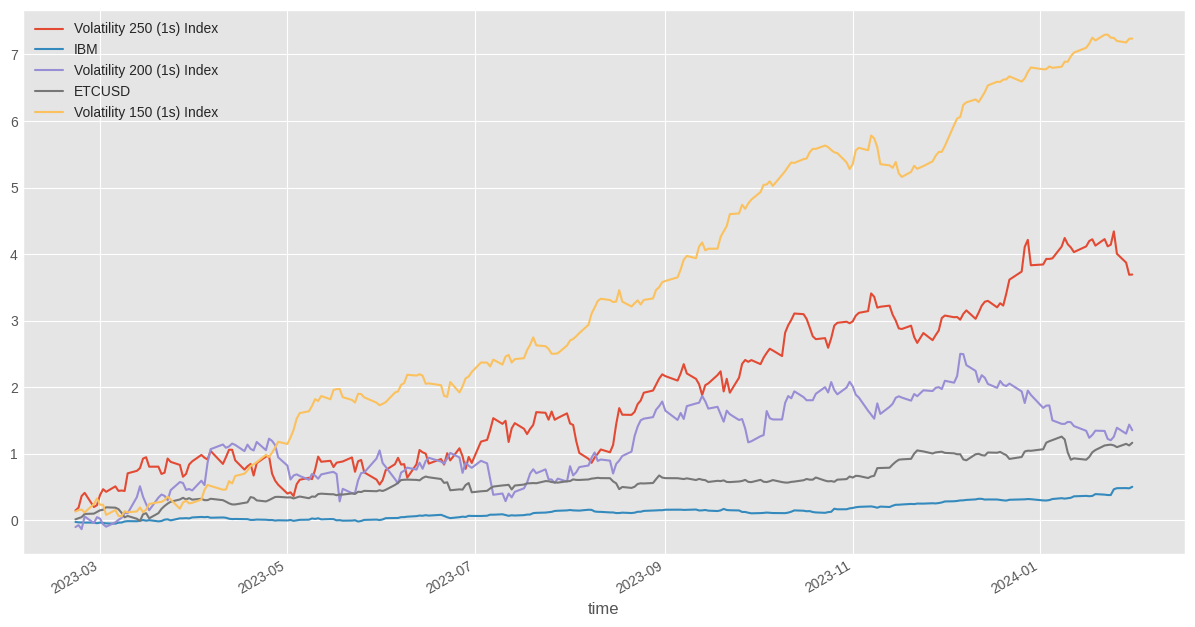

In [57]:
# Display cumulative returns of the strategies on the test set
data = results.dropna().loc["2021-01":"2024-01"]
data.cumsum().plot(figsize=(15,8))

### Apply portfolio management techniques

In [63]:
from packages.tf_trade.tf_trade.portfolio import Portfolio

data = results.dropna().loc["2021-01":"2024-01"]
val = results.dropna().loc["2021-01":]

portfolio = Portfolio(data)
X = portfolio.optimize_portfolio(Portfolio.mv_criterion)

print(np.round(X,3))

spread = spread_threshold # 0.00035
low_portfolio = np.multiply(low_assets,np.transpose(X)).sum(axis=1)
high_portfolio = np.multiply(high_assets,np.transpose(X)).sum(axis=1)


# Compute the cumulative return of the portfolio (CM)
portfolio_return_test = np.multiply(data,np.transpose(X)).sum(axis=1)
portfolio_return_MV = np.multiply(val,np.transpose(X)).sum(axis=1)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2695198775517891
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11
[0.057 0.    0.    0.    0.943]


[*********************100%***********************]  1 of 1 completed



    -----------------------------------------------------------------------------
    Beta: -0.545 	 Alpha: 601.05 %	     Sharpe: 4.675 	 Sortino: 0.513
  -----------------------------------------------------------------------------
    VaR: -18.49 %	 cVaR: -15.78 % 	     VaR/cVaR: 0.854 	 drawdown: 56.43 %
  -----------------------------------------------------------------------------


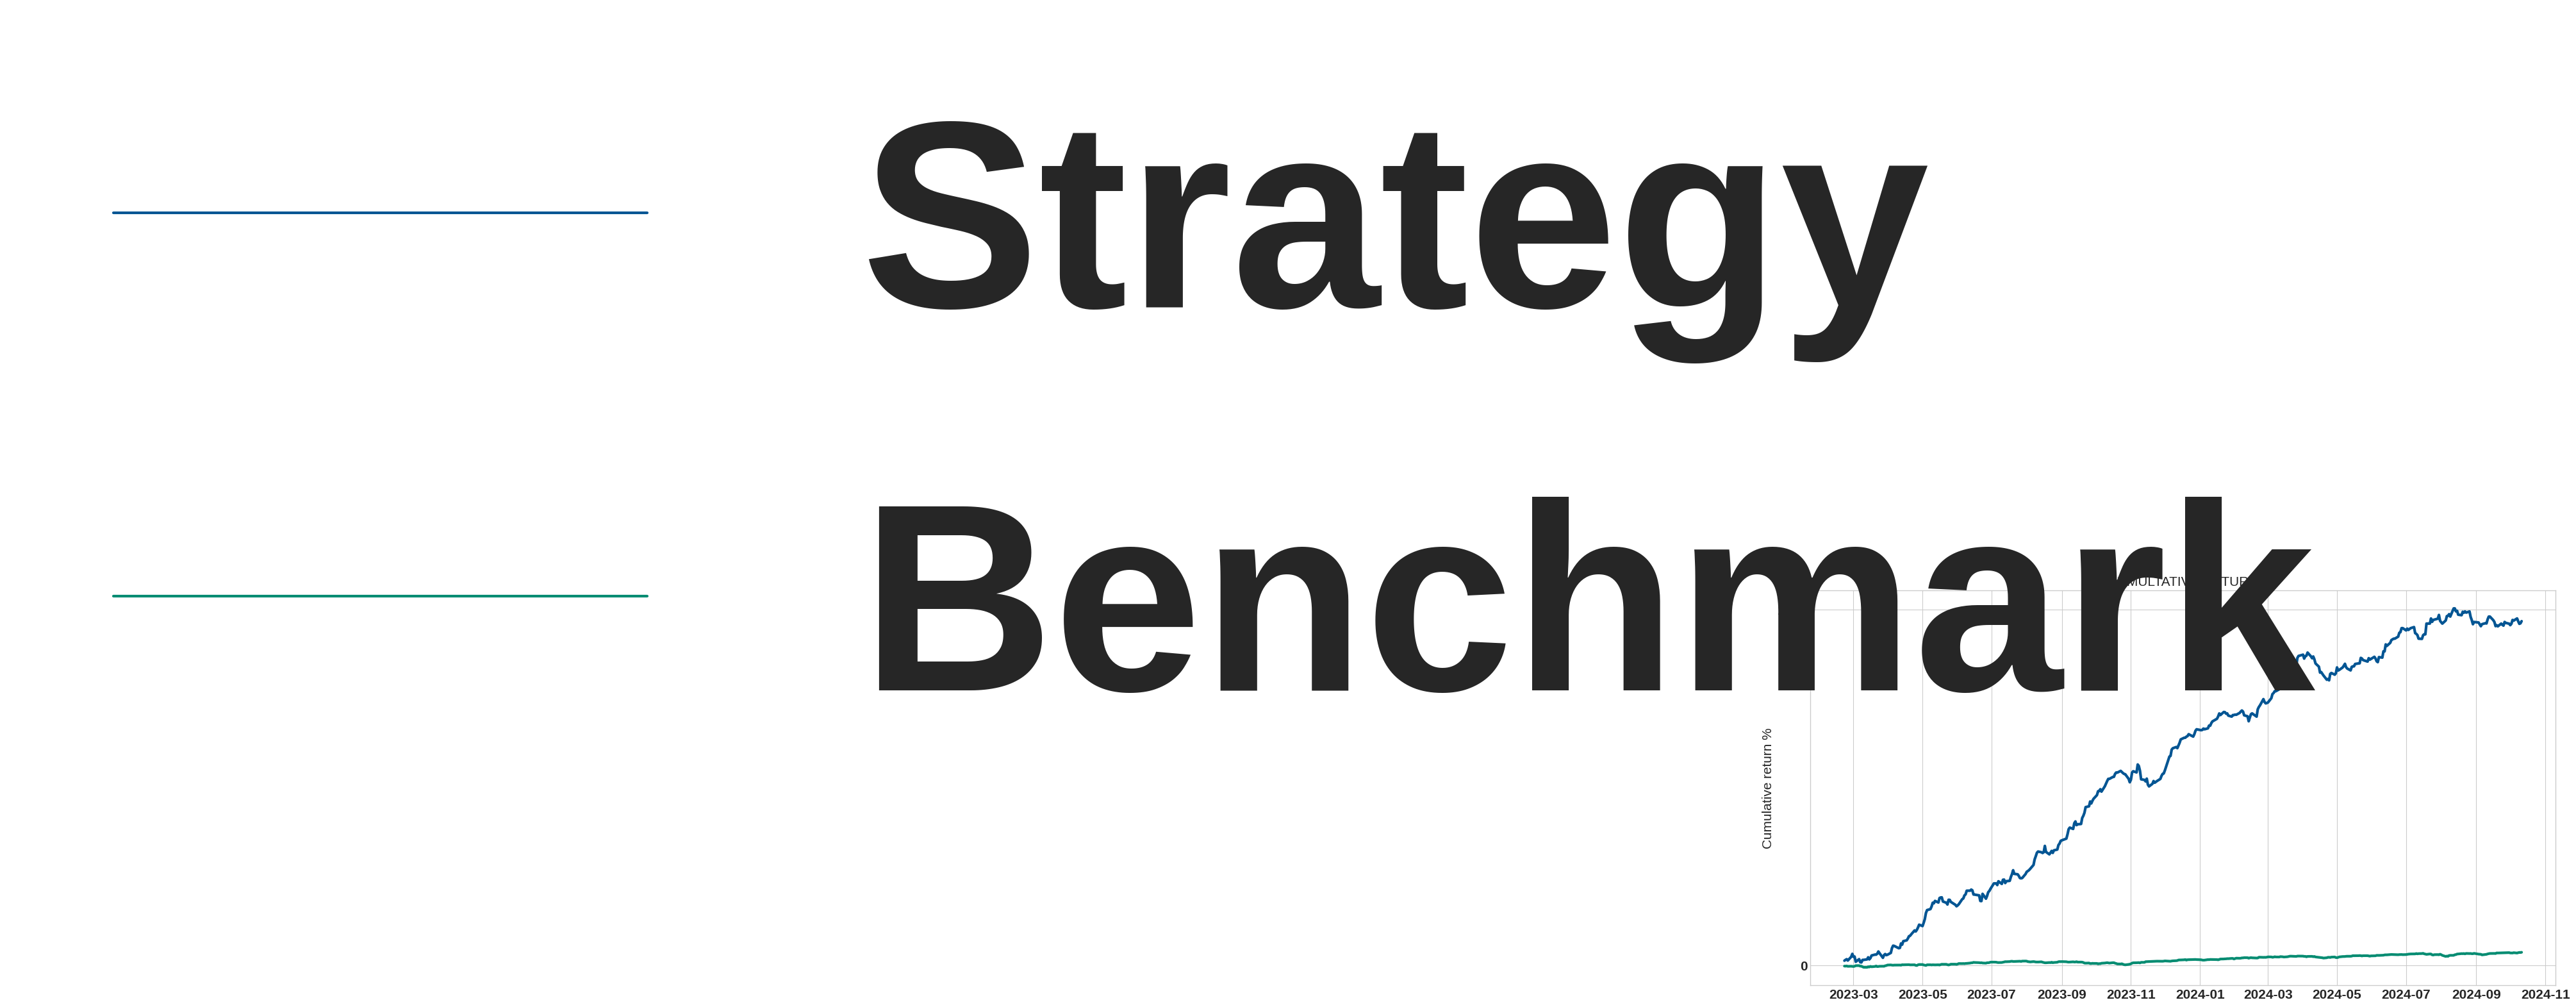

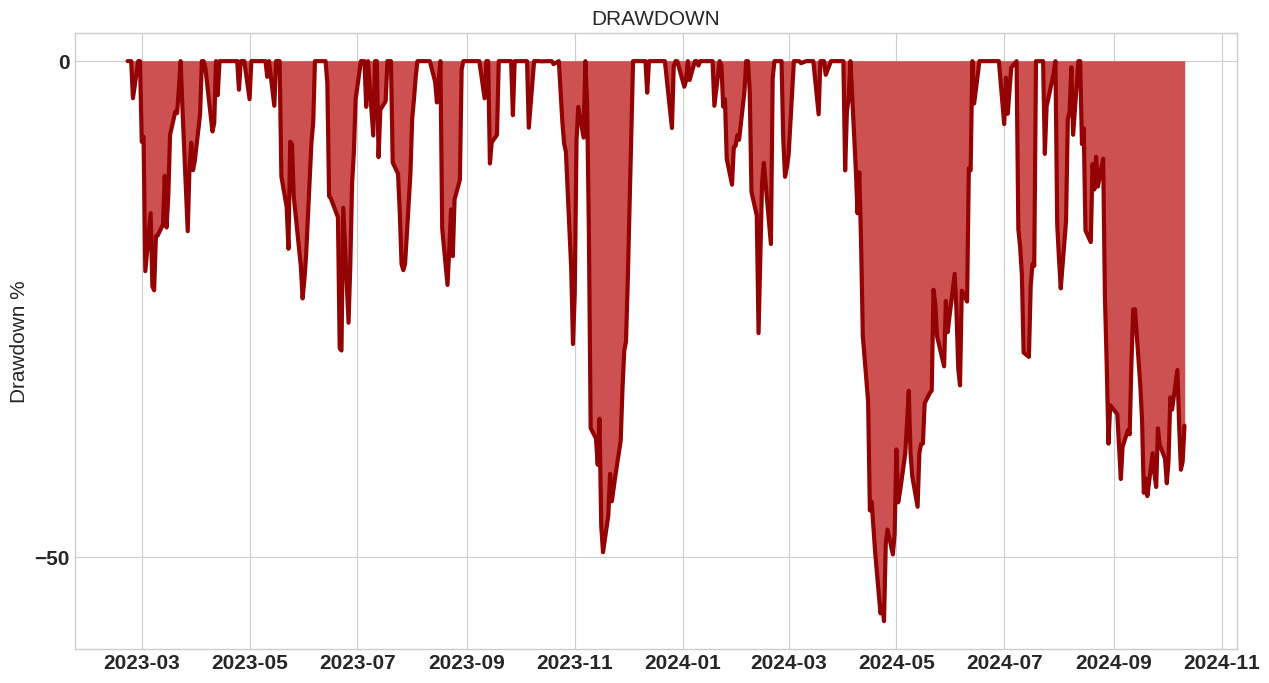

In [65]:
from packages.tf_trade.tf_trade.backtest import *
import yfinance as yf

backtest_dynamic_portfolio(portfolio_return_MV)

### Optimal take profit

In [66]:
def find_best_tp(tp):
    tp = tp/100
    
    # Create the portfolio
    pf = pd.concat((low_portfolio, portfolio_return_test,high_portfolio), axis=1).dropna()-spread
    pf.columns = ["low", "Return", "high"]

    # Apply the tp
    pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
    down = pf["Return"].values
    down = down[down<0]
    
    # Return sharpe raatio
    return np.sqrt(252)*pf["Return"].mean()/down.std()

pd.DataFrame([find_best_tp(tp) for tp in np.linspace(0.5,10,30)],  index=np.linspace(0.5,10,30), columns=["Sharpe"])

,Sharpe
0.500000,0.652813
0.827586,1.255285
1.155172,1.978354
1.482759,2.174784
1.810345,2.583486
2.137931,2.479929
2.465517,2.680874
2.793103,3.028053
3.120690,3.415676
3.448276,4.027515


[*********************100%***********************]  1 of 1 completed



    -----------------------------------------------------------------------------
    Beta: 0.098 	 Alpha: 135.29 %	     Sharpe: 2.074 	 Sortino: 0.103
  -----------------------------------------------------------------------------
    VaR: 1.05 %	 cVaR: 2.44 % 	     VaR/cVaR: 2.332 	 drawdown: 53.2 %
  -----------------------------------------------------------------------------


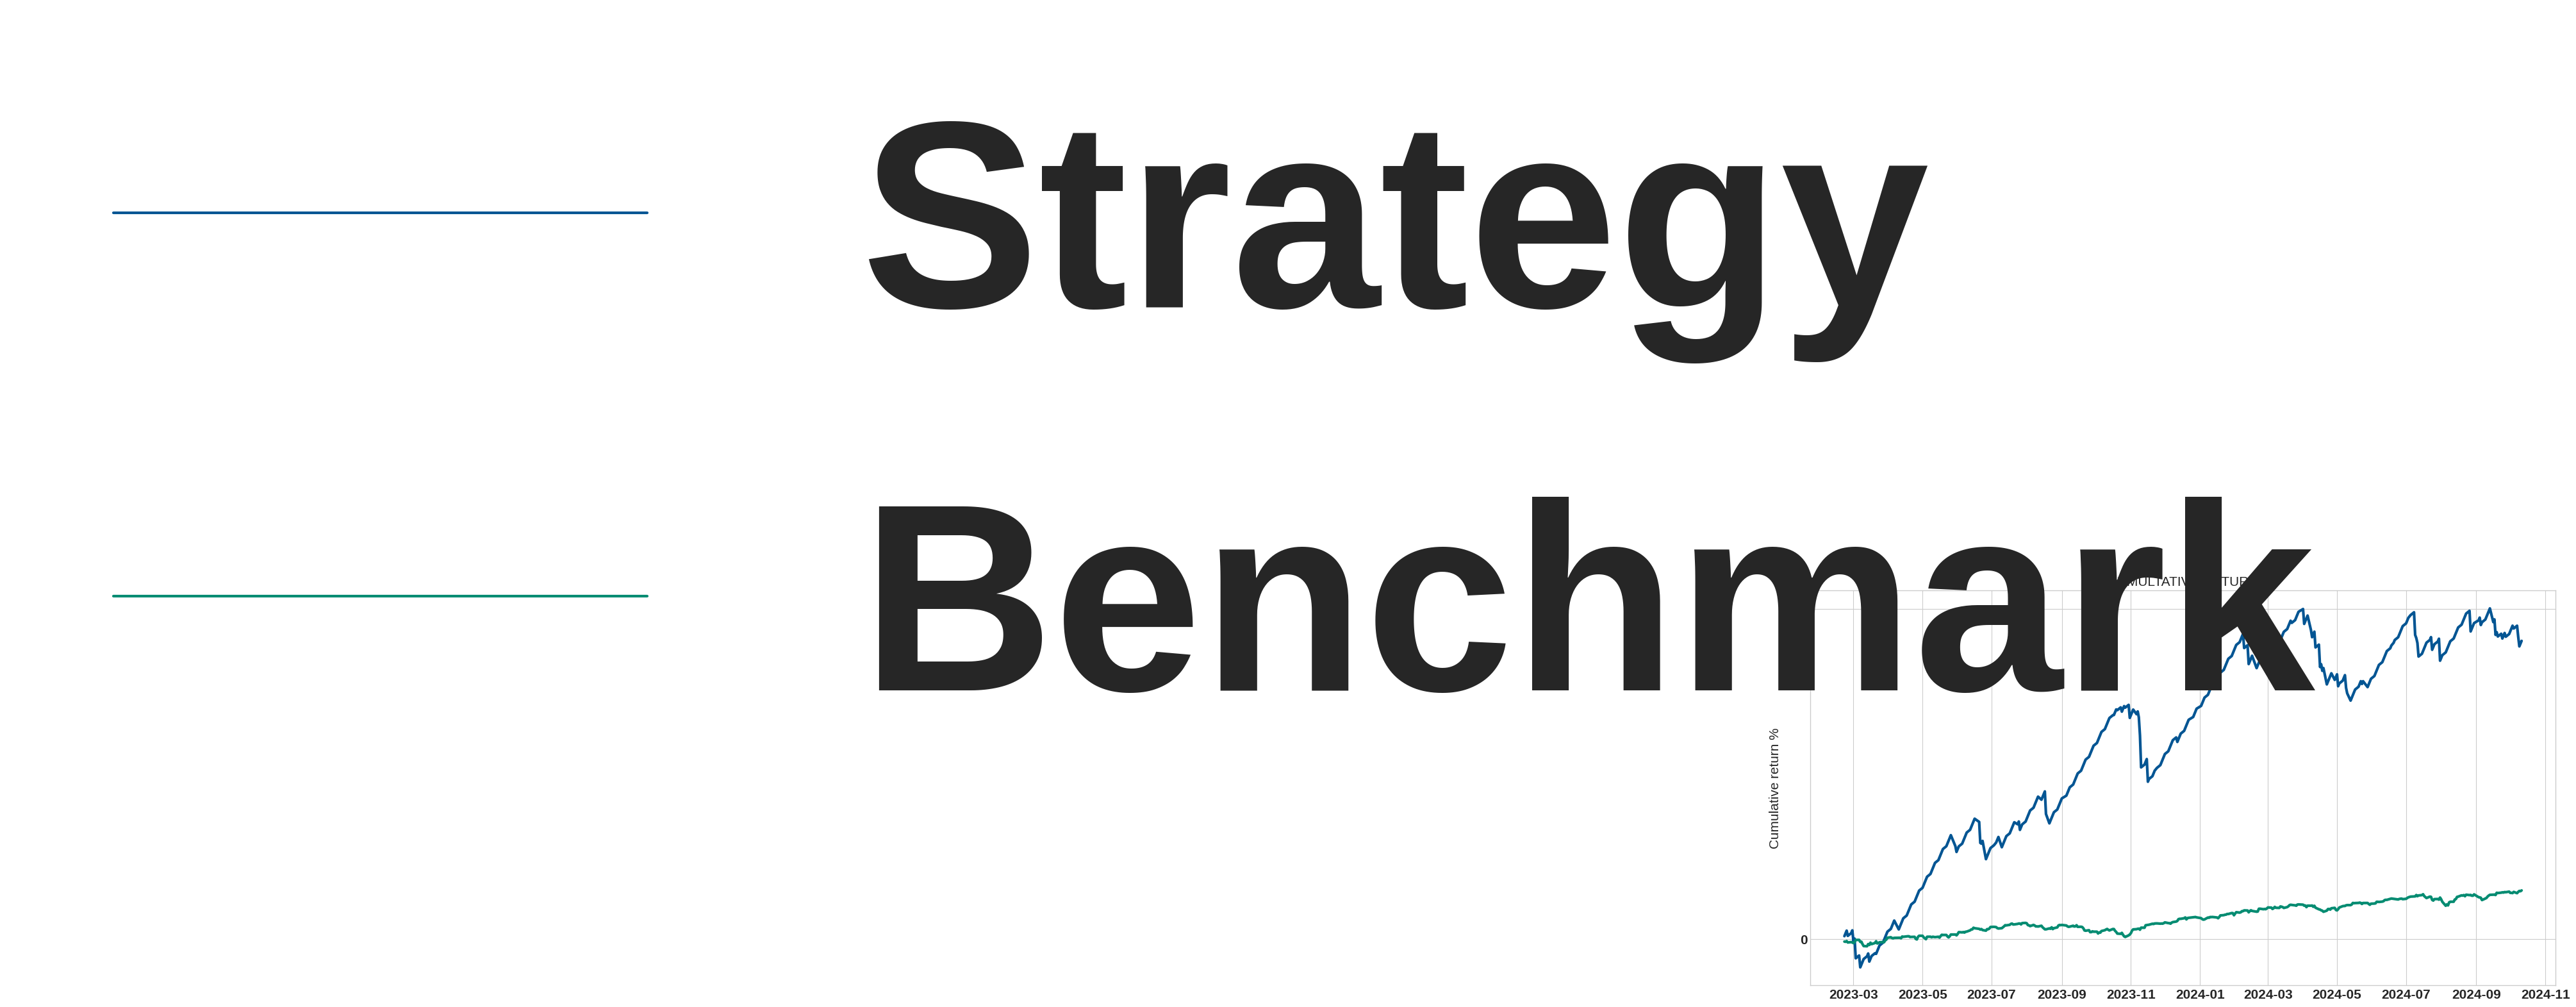

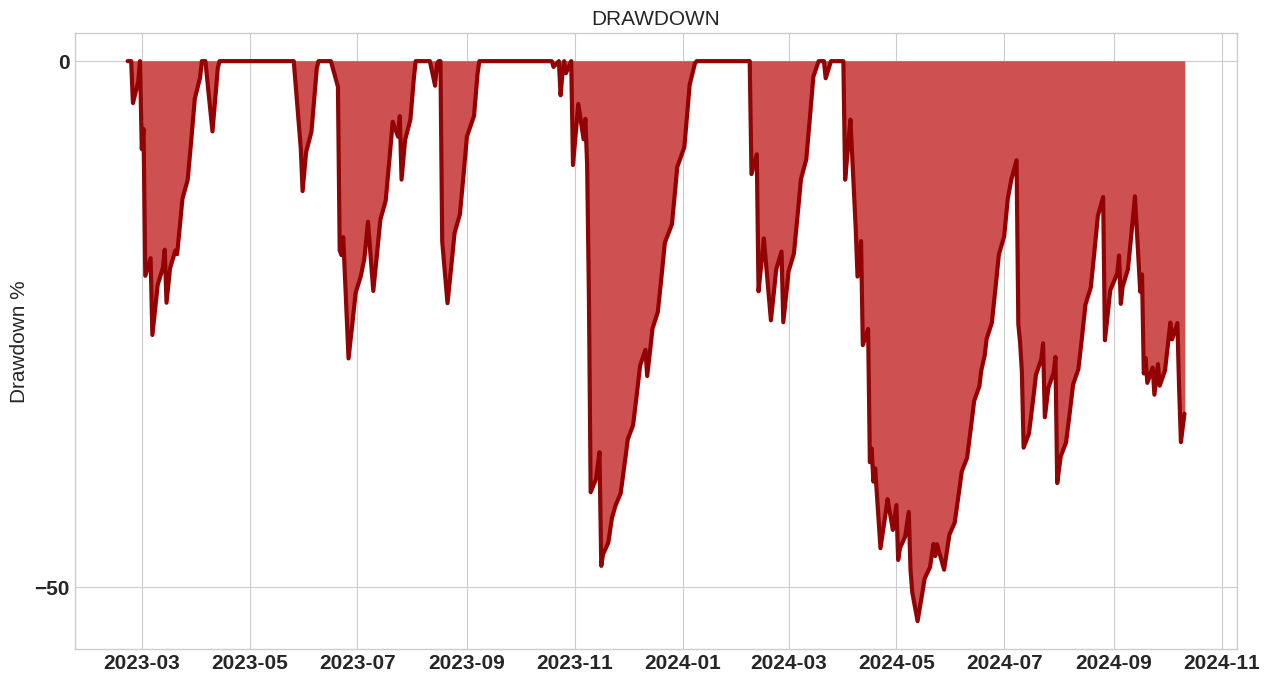

In [67]:
tp = 2.1/100
pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)

backtest_dynamic_portfolio(pf["Return"])

### Optimal stop loss

In [68]:
def find_best_sl(sl):
    sl = sl/100
    
    # Create the portfolio
    pf = pd.concat((low_portfolio, portfolio_return_test,high_portfolio), axis=1).dropna()-spread
    pf.columns = ["low", "Return", "high"]

    # Apply the tp
    pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)
    
    # Return sharpe raatio
    return np.sqrt(252)*pf["Return"].mean()/pf["Return"].std()

pd.DataFrame([find_best_sl(sl) for sl in np.linspace(1,10,30)],  index=np.linspace(1,10,30), columns=["Sharpe"])

,Sharpe
1.000000,-2.916320
1.310345,-0.917915
1.620690,0.570221
1.931034,0.609511
2.241379,1.562921
2.551724,1.851339
2.862069,1.421271
3.172414,1.481469
3.482759,1.773496
3.793103,1.803406


[*********************100%***********************]  1 of 1 completed



    -----------------------------------------------------------------------------
    Beta: -0.579 	 Alpha: 488.92 %	     Sharpe: 3.791 	 Sortino: 0.503
  -----------------------------------------------------------------------------
    VaR: -11.55 %	 cVaR: -8.93 % 	     VaR/cVaR: 0.773 	 drawdown: 57.61 %
  -----------------------------------------------------------------------------


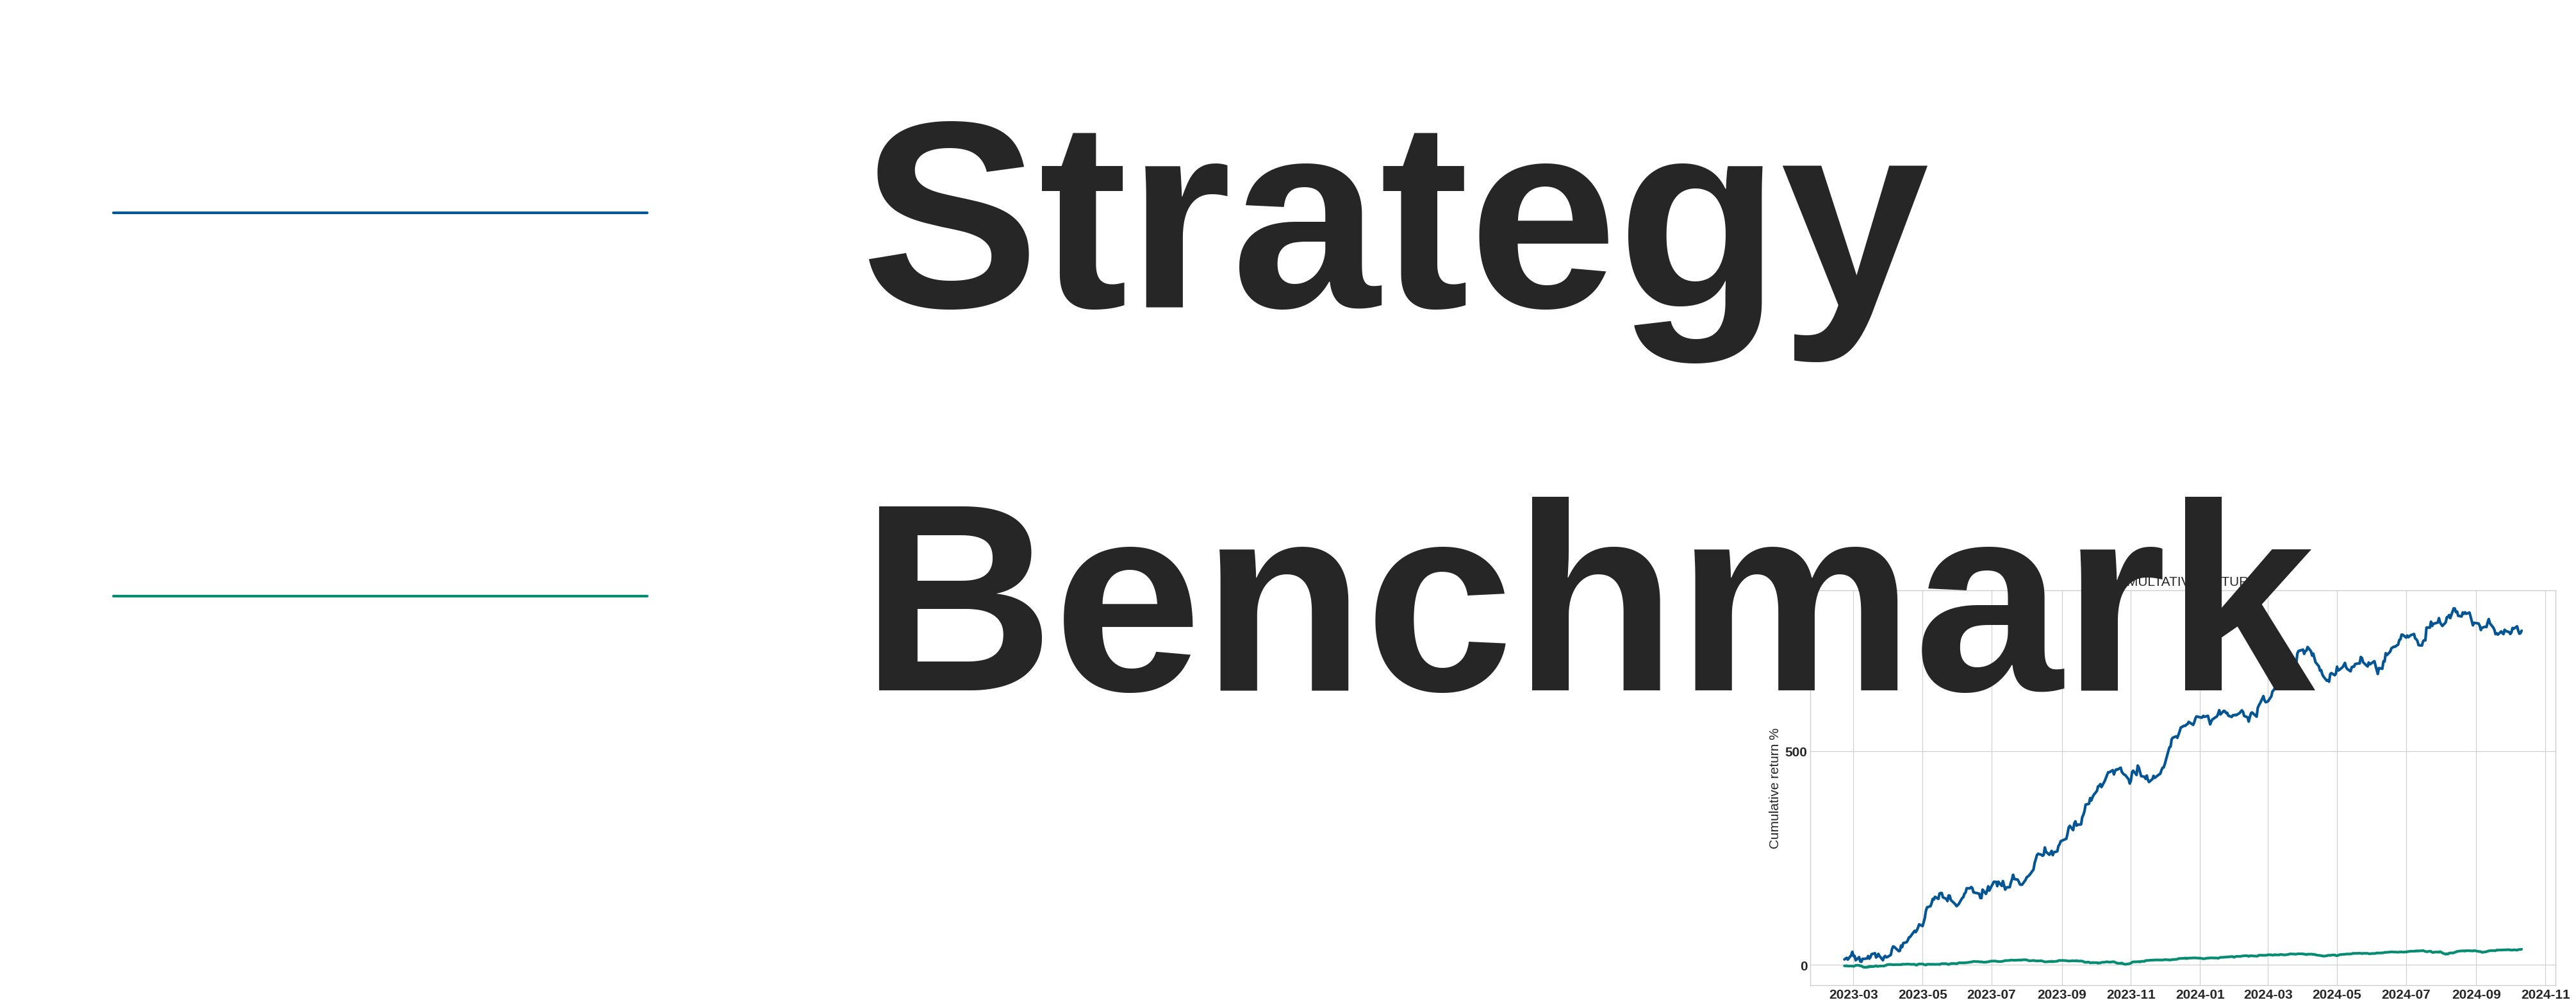

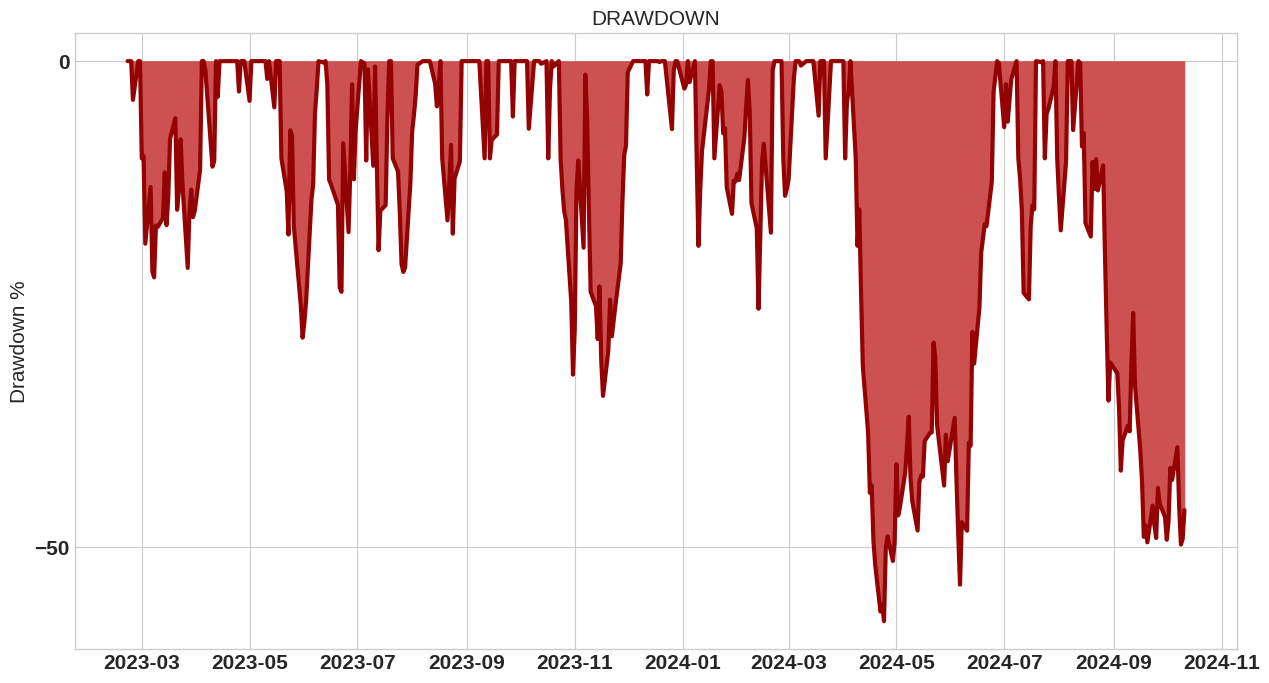

In [69]:
sl = 10/100
pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread

pf.columns = ["low", "Return", "high"]
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)


backtest_dynamic_portfolio(pf["Return"])

### Optimal leverage

[*********************100%***********************]  1 of 1 completed



    -----------------------------------------------------------------------------
    Beta: -0.213 	 Alpha: 586.73 %	     Sharpe: 3.837 	 Sortino: 0.332
  -----------------------------------------------------------------------------
    VaR: -14.2 %	 cVaR: -10.99 % 	     VaR/cVaR: 0.774 	 drawdown: 75.15 %
  -----------------------------------------------------------------------------


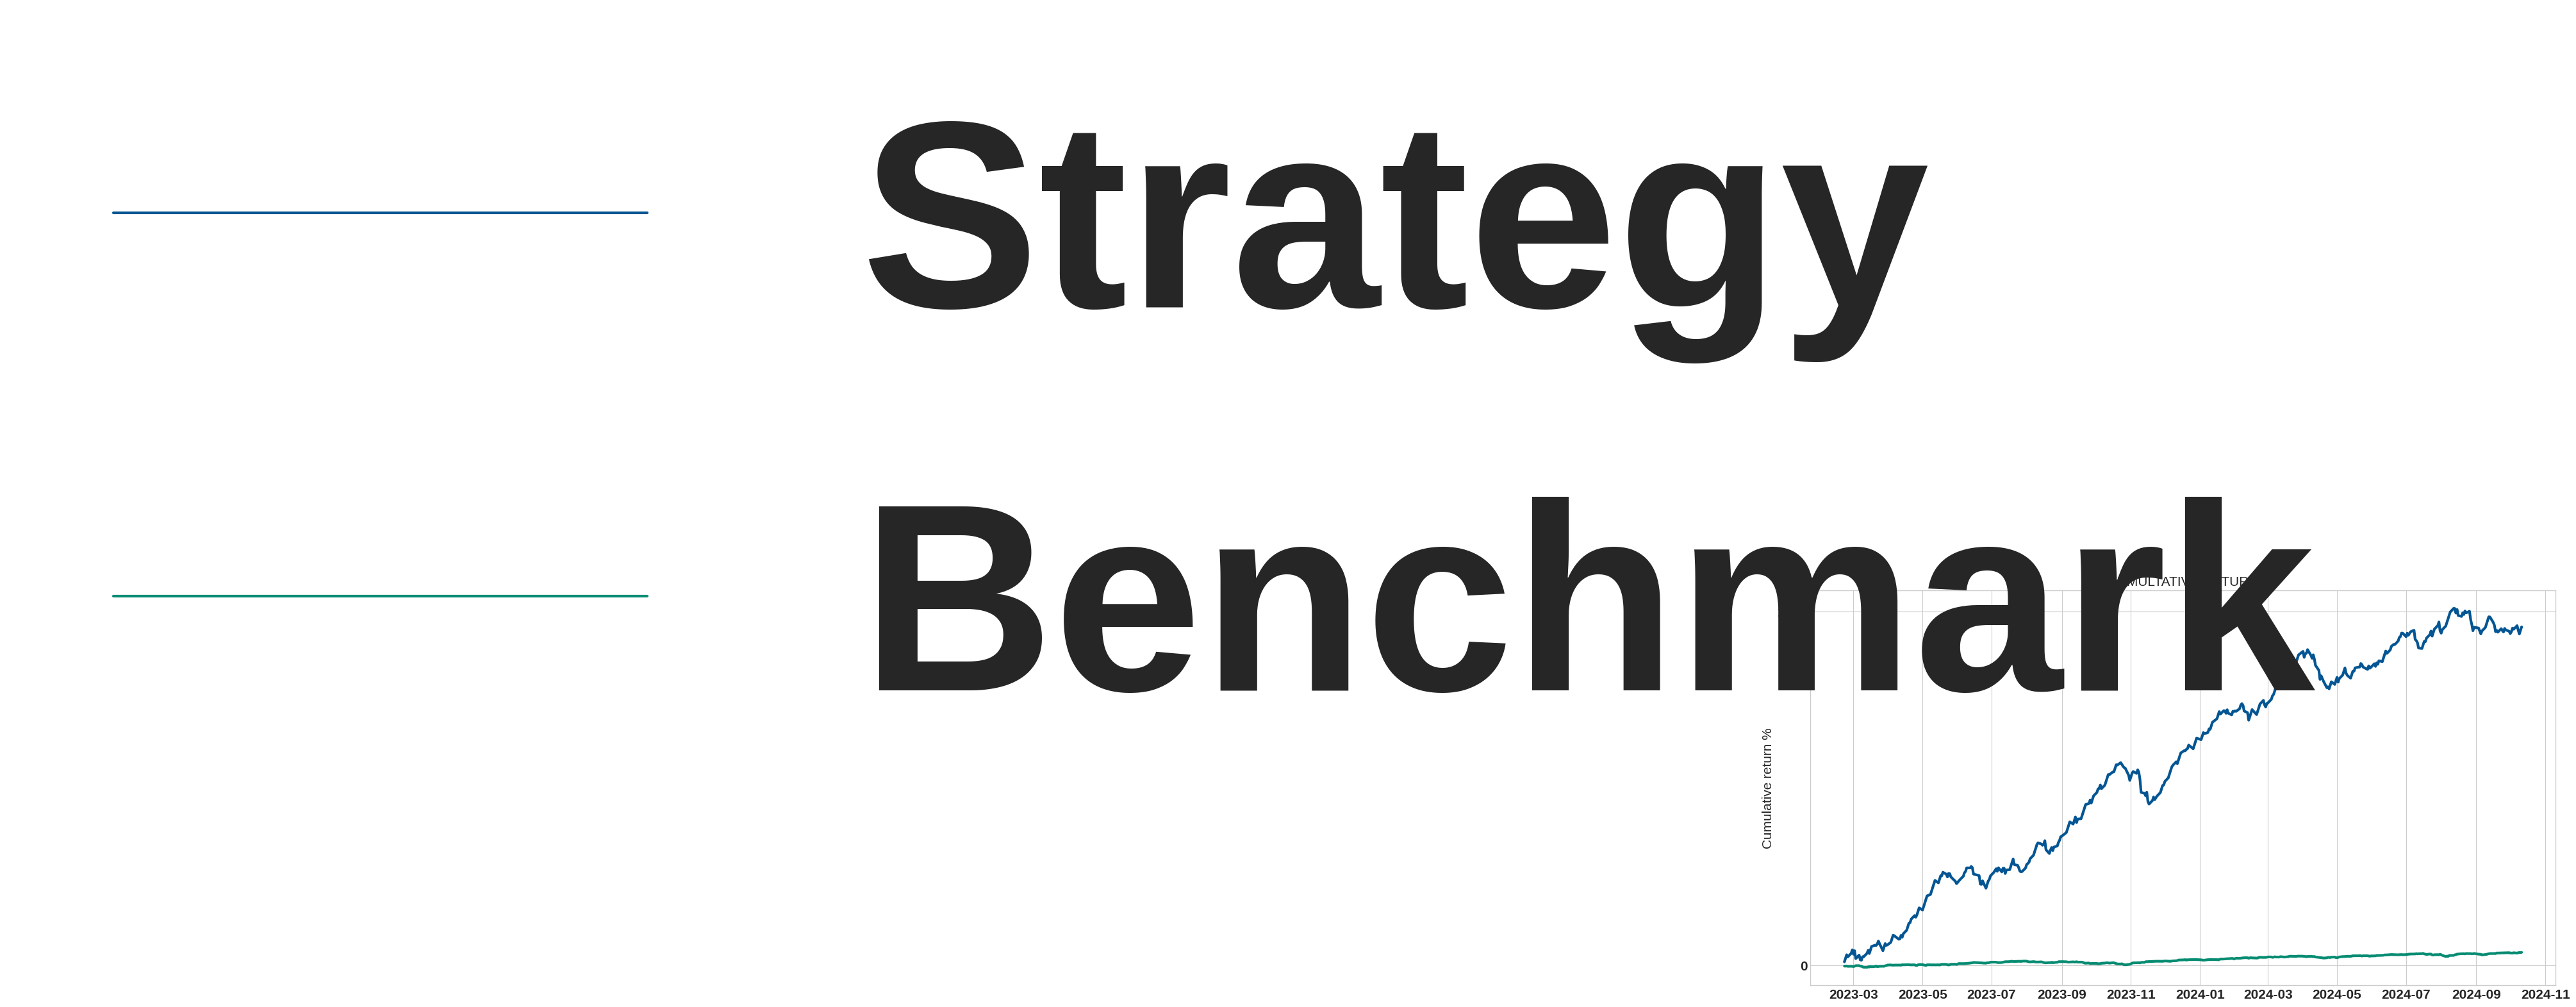

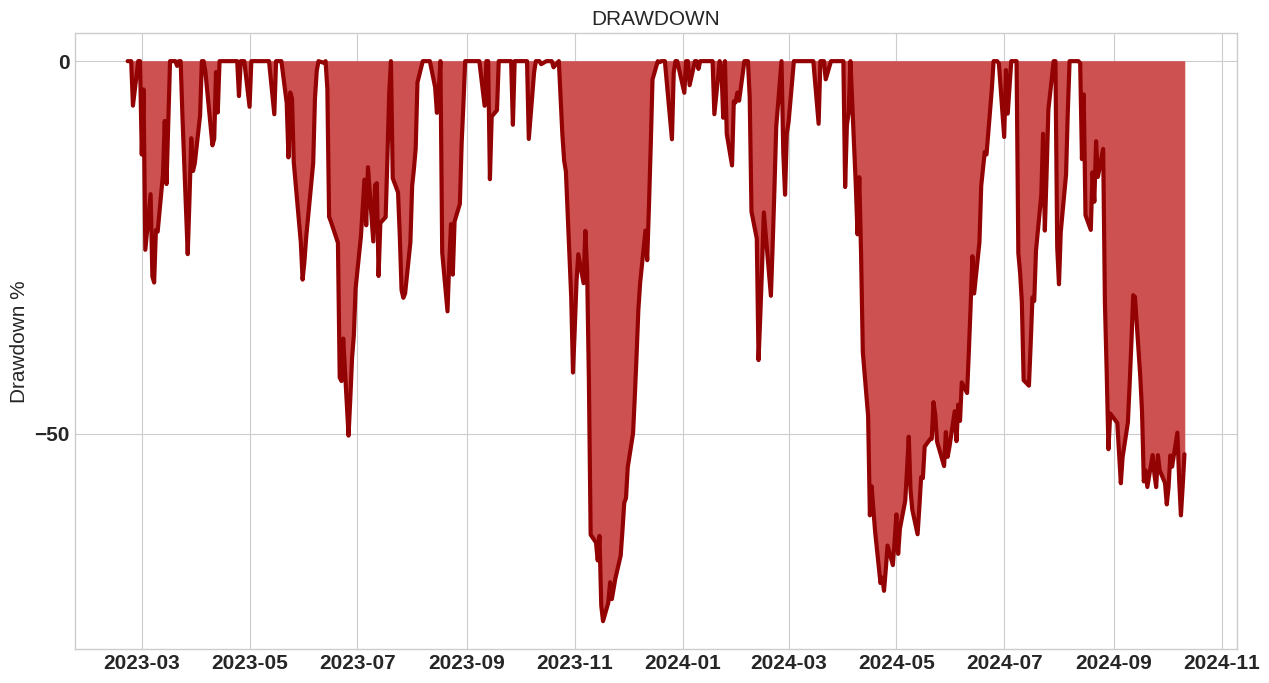

In [71]:
leverage = 1.5
tp = 10/100 # 2.1/100
sl = 10 # 7.3
pf = (pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread)*leverage
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)

# Plot the CM
backtest_dynamic_portfolio(pf["Return"])

Why has the performance does not grown since 06-2021? There are some explanations. The period's volatility is less than the other, and the strategy does not work on it, or the weight of the algorithm needs to be adjusted because the market situation has evolved.